# Problem Statement

Metallic surface defect detection is an essential and necessary process to control the qualities of industrial products. Surface defects have a greatly adverse effect on the quality of industrial products. Metallic defects detection has been exploited to satisfy predefined quality requirements for the industry. Therefore, metallic surface defect detection has attracted increasing interest in recent years and has achieved a positive improvement for the quality control in industrial applications [1](https://scholar.google.com/scholar_lookup?journal=Proceedings+of+the+2017+International+Joint+Conference+on+Neural+Networks+(IJCNN)&title=Transfer+Learning+for+Automated+Optical+Inspection&author=S.+Kim&author=W.+Kim&author=Y.K.+Noh&author=F.C.+Park&pages=2517-2524&)

# Dataset

This notebook explores the [Severstal: Steel Defect Detection]( https://www.kaggle.com/c/severstal-steel-defect-detection) competition. The challenge consists on using images to detect defects on pieces of steel, classify the type of defect (4 types), and identify the location and area of the defect.

For training on TPU data used was contained in TFRecords created and made available on [Kaggle](https://www.kaggle.com/reyvaz/tfrecs-for-severstal-steel-defect-detection) by Reynaldo Vazquez. The code to convert the dataset into TFRecords is available on my github.

# Metric

The metric used here was the Dice coefficient. The formula to calculate the Dice coefficient is given by:

$$
\begin{align*}
\text{Dice coefficient} = \frac{2|\hat{Y} \cap Y|}{|\hat{Y}| + |Y|}
\end{align*}
$$

where $\hat{Y}$ is the predicted set of pixels and $Y$ is the ground truth.

During training, the overall Dice coefficient was calculated in 3 ways: 
1.	<u>Batch-wise average</u> was used for tracking purposes but also for back propagation as part of the Dice based losses.
2.	<u>Image-wise average</u> was the metric chosen to be maximized during training; it provided the most stable and consistent way to compare performance across different specifications.
3.	<u>Channel-wise average</u> (i.e. Dice coefficient was calculated for each type of defect for each image and averaged across examples). This is the official metric used in the competition and it is the metric that can be compared to other works; it was monitored and reported throughout training. It is also the metric reported in the Segmentation Evaluation section below.

# Models

<h3>The model consists of a two-step approach.</h3>

1. The first step is to run the images through an ensemble of binary image neural network classifiers to determine whether the piece of steel in the image presents a  defect.

2. The second step, runs the same image through an ensemble of segmentation neural networks to identify the location of the defect and identify the type of the defect. Images may contain no defects or 1 or more types of defects. Although the bulk of defect examples contain 1 type of defect.  

3. The final inference uses a Triple Thresholding [algorithm](https://imgur.com/a/ExNJ8OI).

# Credits

Reynaldo Vazquez's [notebook](https://colab.research.google.com/github/reyvaz/steel-defect-segmentation/blob/master/steel_defect_detection.ipynb#scrollTo=Vv9MXENak9Ne). 

The notebook has application of several key concepts such as fold training, custom data pipeline, sampling techniques, learning rate scheduer, custom training, weight management etc. which was a complete learning experience

In [ ]:
import os, sys, math, re, gc, random
from time import time, strftime, gmtime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

print('Tensorflow version: ', tf.__version__)


Tensorflow version:  2.7.0


In [ ]:
try: tpu
except:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('TPU not found')
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    else:
        # Default distribution strategy. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

Running on TPU  grpc://10.12.98.122:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.12.98.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.98.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
def verify_gcs_path(GCS_PATH, renew_url):
    '''
    Verifies if a GCS url is valid.
    Used since Kaggle GCS urls expire periodically.
    '''
    try: tf.io.gfile.glob(GCS_PATH + '/*')[0]
    except:
        print('GCS path has expired. Follow this link to renew: ' + renew_url)
        raise Exception('GCS path has expired. Follow this link to renew: ' + renew_url) from None
    print('GCS path is valid')
    return None

In [ ]:
GCS_PATH = 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812'
renew_url = 'https://www.kaggle.com/reyvaz/severstal-tfrecords-gcs-path'
verify_gcs_path(GCS_PATH, renew_url)

GCS path is valid


Tfrecords are divided into 'test', 'train-defect' and 'train-no-defect'

In [ ]:
IMAGE_SIZE = (256, 1600) # Original size of the images
N_DEFECT_CLASSES = 4
N_CHANNELS = 3

target_size = (128, 800)
INPUT_SHAPE = (*target_size, N_CHANNELS)

# https://stackoverflow.com/questions/66005641/why-we-are-using-strategy-num-replicas-in-sync
N_REPLICAS = strategy.num_replicas_in_sync

classes = ['No Defects', 'Defects']

tfr_gcs_path = GCS_PATH + '/tfrecs/'
TFRECS_DEFECT = tf.io.gfile.glob(tfr_gcs_path + '*train-defect*.tfrec')
TFRECS_NODEFECT = tf.io.gfile.glob(tfr_gcs_path + '*train-no-defect*.tfrec')

N_TFRECS_DEFECT = len(TFRECS_DEFECT) # 20 
N_TFRECS_NODEFECT = len(TFRECS_NODEFECT) # 20

In [ ]:
TFRECS_DEFECT

['gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-01-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-02-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-03-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-04-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-05-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-06-334.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-07-333.tfrec',
 'gs://kds-c63128607f2f277a7675054bf4413bed77e09f738dc56fbf80a62812/tfrecs/severstal-256x1600-train-defect-08-333.tfrec',
 'gs://kds-c63128607f2f2

In [ ]:
def parse_tfrecord_fn(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        }
    features['rle'] = tf.io.FixedLenFeature([4], tf.string)
    features['label'] = tf.io.FixedLenFeature([], tf.int64)

    example = tf.io.parse_single_example(example, features)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

height: 1600
img_id: b'000a4bcdd'
label: 1
rle: [b'37607 3 37858 8 38108 14 38359 20 38610 25 38863 28 39119 28 39375 29 39631 29 39887 29 40143 29 40399 29 40655 30 40911 30 41167 30 41423 30 41679 31 41935 31 42191 31 42447 31 42703 31 42960 31 43216 31 43472 31 43728 31 43984 31 44240 32 44496 32 44752 32 45008 32 45264 33 45520 33 45776 33 46032 33 46288 33 46544 34 46803 31 47065 25 47327 19 47588 15 47850 9 48112 3 62667 12 62923 23 63179 23 63348 3 63435 23 63604 7 63691 23 63860 11 63947 23 64116 15 64203 23 64372 19 64459 23 64628 24 64715 23 64884 28 64971 23 65139 33 65227 23 65395 37 65483 23 65651 41 65740 22 65907 45 65996 22 66163 48 66252 22 66419 48 66508 22 66675 48 66764 22 66931 48 67020 22 67187 48 67276 20 67443 48 67532 16 67699 48 67788 13 67955 48 68044 9 68210 49 68300 6 68466 49 68556 2 68722 50 68978 50 69234 50 69490 50 69746 50 70009 43 70277 31 70545 19 70813 7 73363 5 73619 14 73875 23 74131 31 74387 40 74643 45 74899 46 75155 46 75411 47 75667 47 75923 

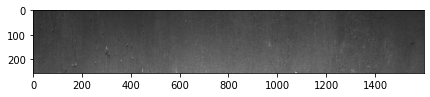

height: 1600
img_id: b'00c88fed0'
label: 1
rle: [b'10474 7 10728 15 10983 18 11239 21 11494 24 11749 27 12005 27 12260 28 12516 28 12772 28 13028 28 13285 27 13543 25 13800 24 14058 22 14317 19 14576 15 14834 13 15092 11'
 b'13428 8 13684 24 13940 39 14196 55 14452 71 14707 87 14963 103 15219 118 15475 134 15618 12 15731 142 15874 35 15995 134 16130 57 16267 118 16386 80 16539 102 16642 103 16810 87 16898 126 17082 71 17154 148 17354 55 17410 171 17625 40 17666 183 17897 24 17922 183 18169 8 18178 183 18434 183 18690 183 18946 183 19202 183 19458 183 19714 183 19970 183 20226 164 20482 128 20738 91 20994 55 21250 19'
 b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


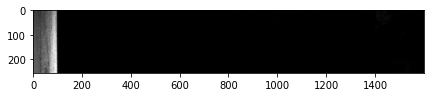

height: 1600
img_id: b'016af13d0'
label: 1
rle: [b'1 0' b'1 0'
 b'9985 26 10241 77 10497 128 10753 179 11009 230 11265 7040 47212 148 47467 149 47722 150 47977 151 48232 152 48487 153 48742 154 48997 155 49253 155 49409 8 49508 156 49665 24 49763 157 49921 39 50018 158 50177 55 50273 159 50433 70 50528 160 50689 86 50783 161 50945 255 51201 255 51457 255 51713 255 51969 255 52225 255 52481 255 52737 255 52993 255 53250 254 53506 254 53762 254 54018 254 54274 254 54530 254 54786 254 55042 254 55298 254 55554 254 55810 254 56066 254 56322 254 56578 254 56834 254 57090 254 57346 254 57602 254 57858 254 58114 254 58370 254 58626 254 58882 254 59138 254 59394 254 59650 254 59906 254 60162 254 60418 254 60675 253 60931 253 61187 253 61443 253 61699 253 61955 253 62211 253 62467 253 62723 253 62979 253 63235 253 63491 253 63747 253 64003 253 64259 253 64515 253 64771 253 65027 253 65283 253 65539 253 65795 253 66051 253 66307 253 66563 253 66819 236 67075 203 67331 169 67587 136 67844 118 681

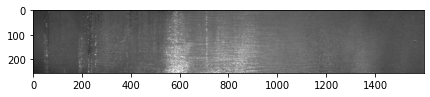

height: 1600
img_id: b'0217af9b1'
label: 1
rle: [b'1 0' b'1 0' b'86017 64 86273 192 86529 4608 91265 128' b'1 0']
width: 256
Image shape: (256, 1600, 3)


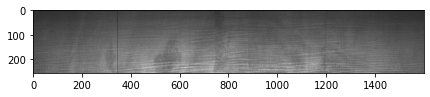

height: 1600
img_id: b'031627893'
label: 1
rle: [b'1 0' b'1 0'
 b'114267 3 114522 9 114777 14 115032 17 115287 21 115541 26 115796 29 116051 33 116306 36 116561 39 116816 40 117071 42 117326 43 117581 45 117835 47 118090 49 118345 50 118600 52 118855 53 119110 55 119366 55 119622 56 119878 56 120134 57 120390 57 120646 58 120902 58 121158 59 121414 59 121670 60 121925 61 122181 62 122437 62 122693 63 122949 63 123205 64 123461 64 123717 65 123973 65 124229 66 124485 66 124741 67 124997 67 125253 68 125509 68 125765 69 126021 69 126277 70 126533 70 126789 71 127045 71 127300 73 127556 73 127812 74 128068 74 128324 75 128580 75 128836 76 129092 76 129348 76 129604 76 129860 76 130116 76 130372 76 130628 76 130884 76 131140 76 131396 76 131652 76 131908 76 132164 77 132420 77 132675 78 132931 78 133187 78 133443 78 133699 78 133955 78 134211 78 134467 78 134723 78 134979 78 135235 78 135491 78 135747 78 136003 78 136259 78 136515 78 136771 78 137027 78 137283 78 137539 78 137795 78 138051

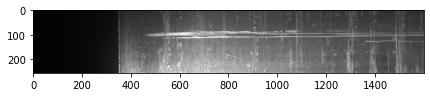

height: 1600
img_id: b'04055fd3e'
label: 1
rle: [b'1 0' b'1 0'
 b'175073 32 175265 96 175457 160 175649 6325 182017 128 182273 43 269825 128 270081 4096 371970 28 372226 83 372482 139 372738 194 372994 222 373250 222 373506 222 373762 222 374018 222 374273 223 374529 223 374785 223 375041 223 375297 223 375553 223 375809 223 376065 167 376321 56'
 b'1 0']
width: 256
Image shape: (256, 1600, 3)


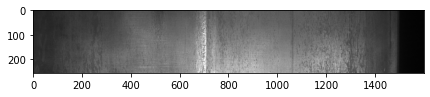

height: 1600
img_id: b'04d49c95d'
label: 1
rle: [b'1 0' b'1 0'
 b'176086 43 176257 128 176428 5077 249091 43 249347 127 249603 211 249859 254 250115 254 250371 254 250627 254 250883 254 251139 254 251395 254 251651 254 251907 254 252163 254 252419 254 252675 254 252931 254 253187 254 253443 254 253700 253 253956 253 254212 253 254468 253 254724 253 254980 253 255236 253 255492 253 255748 253 256004 253 256260 253 256516 232 256766 3 256772 196 257024 1 257028 161 257284 125 257540 89 257796 54 258052 18'
 b'1 0']
width: 256
Image shape: (256, 1600, 3)


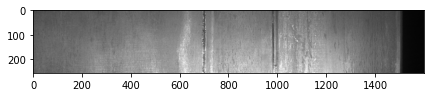

height: 1600
img_id: b'059000a4f'
label: 1
rle: [b'350118 6 350369 12 350622 15 350877 16 351133 17 351388 18 351644 17 351899 18 352154 18 352410 17 352665 16 352921 14 353166 23 353422 23 353677 24 353934 23 354190 22 354447 21 354703 21 354960 20 355216 20 355473 19 355729 19 355986 18 356244 16 356507 9 356763 8 357020 7 357276 7 357532 7 357788 7 358044 7 358302 5'
 b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


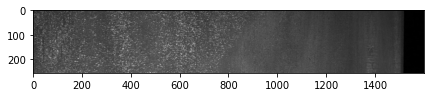

height: 1600
img_id: b'06ad83bac'
label: 1
rle: [b'1 0' b'1 0'
 b'122 32 239 13 377 32 494 13 633 32 749 14 888 32 1004 14 1144 31 1259 15 1399 32 1514 15 1655 31 1769 16 1910 31 2024 16 2166 31 2279 16 2421 31 2534 17 2677 30 2789 17 2932 31 3044 18 3188 30 3299 18 3443 30 3554 19 3699 30 3809 19 3954 30 4064 19 4210 29 4319 20 4465 29 4574 20 4721 29 4829 21 4976 29 5084 21 5231 29 5339 22 5487 29 5594 22 5742 29 5849 22 5998 28 6104 23 6253 29 6359 23 6509 28 6614 24 6764 28 6869 24 7020 28 7124 25 7275 28 7379 25 7531 27 7634 25 7786 28 7889 26 8042 27 8144 26 8297 27 8399 27 8553 27 8654 27 8808 27 8909 28 9064 26 9164 28 9319 27 9419 28 9574 27 9674 29 9830 26 9929 29 10085 27 10184 30 10341 26 10439 30 10596 26 10694 31 10852 26 10949 31 11107 26 11204 31 11363 25 11459 32 11618 25 11714 32 11874 25 11969 33 12129 25 12224 33 12384 25 12479 34 12640 25 12734 34 12895 25 12989 34 13151 24 13244 35 13406 25 13499 35 13662 24 13754 36 13917 24 14009 36 14173 24 14264 37 14428 24 14

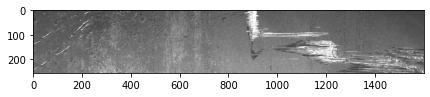

height: 1600
img_id: b'079054aa2'
label: 1
rle: [b'1 0' b'1 0'
 b'332662 4 332913 11 333164 19 333414 27 333663 36 333913 45 334162 54 334412 63 334662 71 334912 79 335162 88 335412 96 335662 104 335914 108 336170 108 336426 108 336682 108 336938 108 337194 108 337450 108 337706 108 337962 108 338218 108 338474 108 338731 107 338987 107 339243 107 339499 107 339755 106 340011 106 340267 105 340523 104 340779 103 341035 103 341291 102 341551 97 341814 89 342077 82 342340 74 342602 67 342865 59 343128 52 343392 43 343657 33 343922 23 344186 15 344451 5'
 b'1 0']
width: 256
Image shape: (256, 1600, 3)


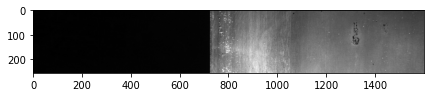

In [ ]:
        raw_dataset = tf.data.TFRecordDataset(TFRECS_DEFECT[2])
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(10):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

height: 1600
img_id: b'7db619168'
label: 0
rle: [b'1 0' b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


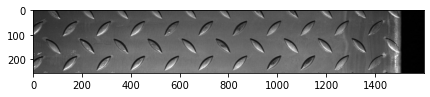

height: 1600
img_id: b'e39c0bbac'
label: 0
rle: [b'1 0' b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


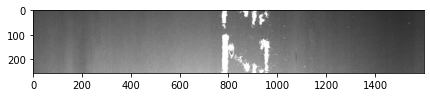

height: 1600
img_id: b'611ed97fe'
label: 0
rle: [b'1 0' b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


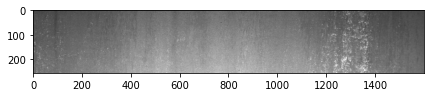

height: 1600
img_id: b'8d7f2d82b'
label: 0
rle: [b'1 0' b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


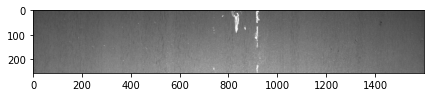

height: 1600
img_id: b'31c047fae'
label: 0
rle: [b'1 0' b'1 0' b'1 0' b'1 0']
width: 256
Image shape: (256, 1600, 3)


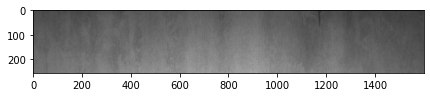

In [ ]:
raw_dataset = tf.data.TFRecordDataset(TFRECS_NODEFECT[15])
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(5):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [ ]:
def count_data_items(filenames):
    '''
    counts the number of data items when counts are written in the name of
    the .tfrec files
    '''
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
masked_examples = count_data_items(TFRECS_DEFECT)
unmasked_examples = count_data_items(TFRECS_NODEFECT)
class_ratio = unmasked_examples / masked_examples

N_EXAMPLES = masked_examples + unmasked_examples
print('Number of examples (total):', N_EXAMPLES)

print('Number of MASKED examples (i.e. with defects):', masked_examples)
print('Number of NON MASKED examples (i.e. with no defects):', unmasked_examples)

Number of examples (total): 12568
Number of MASKED examples (i.e. with defects): 6666
Number of NON MASKED examples (i.e. with no defects): 5902


The `'train.csv'` file contains mask information provided by Severstal. Other file count information was embedded in the TFRec file names, implied from the original JPG files. 

Images with no defects are not listed in the `'train.csv'`. Encoded-pixels are listed only if the image has the type of defect specified in the column `ClassId`. 

**Binary Classes**

The training dataset contains 12568 examples. Of those, 6666 correspond to examples with at least 1 defect; 5902 correspond to examples without defects. Random partitions of the data for training and validation should yield fairly balanced datasets in terms of the binary classes {'No Defects', 'Defects'} thus, maximization of accuracy seems appropriate for the binary classification task. 

**Defect (Segmentation) Classes**

The dataset contains the encodings for 7095 masks; individual examples may contain more than 1 class of defect. 


In [ ]:
!gsutil -q cp {GCS_PATH}/train.csv ./
df = pd.read_csv('train.csv')
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
n_masks = df.shape[0]
n_masked = len(np.unique(df.ImageId))

print('Number of masks:', n_masks)
print('Number of masked examples:', n_masked)

Number of masks: 7095
Number of masked examples: 6666


## Defect Class analysis

In [ ]:
class_counts = df.groupby('ClassId').count()[['ImageId']]
class_counts.columns = ['counts']
class_counts['freq'] = class_counts.counts / df.ImageId.nunique()
class_counts['assigned_class'] = class_counts.index -1 # only for indexing during dev
class_counts

,counts,freq,assigned_class
ClassId,,,
1,897,0.134563,0
2,247,0.037054,1
3,5150,0.772577,2
4,801,0.120162,3


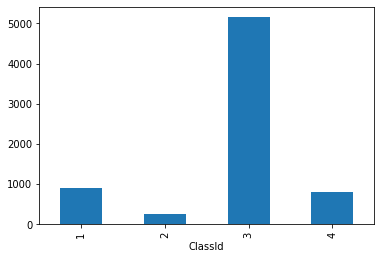

In [ ]:
class_counts['counts'].plot(kind='bar');

In [ ]:
masks_per_image = df.groupby('ImageId').count()
freq_mask_nums = [sum(masks_per_image.ClassId == n) for n in [1, 2, 3, 4]]

for m, n in enumerate([unmasked_examples]+freq_mask_nums):
    print('Num images with {} types of defects: {}'.format(m, n))

Num images with 0 types of defects: 5902
Num images with 1 types of defects: 6239
Num images with 2 types of defects: 425
Num images with 3 types of defects: 2
Num images with 4 types of defects: 0


In [ ]:
label_data = []

for i in df.ImageId.unique():
  label_encode = np.zeros(4)
  for j in df[df.ImageId==i].ClassId.tolist():
    label_encode[j-1] = 1

  multi_label = []

  labels = df[df.ImageId==i].ClassId.tolist()
  if len(labels) == 1:
    multi_label.append(labels[0])
  else:
    multi_label.append(5)  # 5 indicates multiple defects

  label_data.append([i, label_encode.tolist(), multi_label])

## Determine defect thresholds
Find sum of encoded pixels for each class and visualize distribution of each which will later be used for final inference

In [ ]:
image_id = pd.DataFrame(list(map(lambda x:x[0], label_data)), columns=['ImageId'])
defect = pd.DataFrame(list(map(lambda x:x[1], label_data)), columns=['class_1', 'class_2', 'class_3', 'class_4'])
multi_label_df = pd.concat([image_id, defect], axis=1)
multi_label_df['Class'] = list(map(lambda x:x[2][0], label_data))
multi_label_df.head()

,ImageId,class_1,class_2,class_3,class_4,Class
0,0002cc93b.jpg,1.0,0.0,0.0,0.0,1
1,0007a71bf.jpg,0.0,0.0,1.0,0.0,3
2,000a4bcdd.jpg,1.0,0.0,0.0,0.0,1
3,000f6bf48.jpg,0.0,0.0,0.0,1.0,4
4,0014fce06.jpg,0.0,0.0,1.0,0.0,3


In [ ]:
def rle_distribution(df, class_label):
    sum_rle = []
    for i in range(df.shape[0]):
        if df['ClassId'][i] == class_label:
            pixel = df['EncodedPixels'][i].split(' ')[1::2]
            sum_pixel = 0
            for value in pixel:
                sum_pixel += int(value)
            sum_rle.append(sum_pixel)
        else:
            sum_rle.append(0) 

    col_prefix = f'sum_rles_{class_label}'
    df[f'{col_prefix}'] = sum_rle
    data = df[df[f'{col_prefix}'] != 0][f'{col_prefix}']

    # Plot
    plt.figure(figsize=(6, 6))
    sns.displot(data)
    plt.show()
   
    # Percentile
    for i in range(0, 100, 10):
        s = np.sort(data, axis = None)
        print(f"{i} percentile value : {s[int(len(s) * (float(i) / 100))]}")
    print(f"100 percentile value : {s[-1]}")

<Figure size 432x432 with 0 Axes>

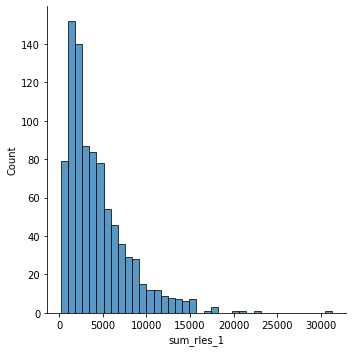

0 percentile value : 163
10 percentile value : 1061
20 percentile value : 1539
30 percentile value : 2059
40 percentile value : 2574
50 percentile value : 3326
60 percentile value : 4205
70 percentile value : 5196
80 percentile value : 6687
90 percentile value : 9000
100 percentile value : 31303


In [ ]:
# Defect class 1

rle_distribution(df, 1)

<Figure size 432x432 with 0 Axes>

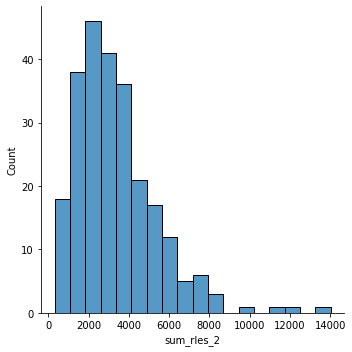

0 percentile value : 316
10 percentile value : 1209
20 percentile value : 1635
30 percentile value : 2172
40 percentile value : 2583
50 percentile value : 2944
60 percentile value : 3448
70 percentile value : 3989
80 percentile value : 4774
90 percentile value : 5914
100 percentile value : 14023


In [ ]:
# Defect class 2

rle_distribution(df, 2)

<Figure size 432x432 with 0 Axes>

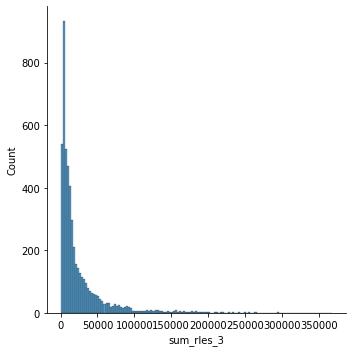

0 percentile value : 115
10 percentile value : 2787
20 percentile value : 4280
30 percentile value : 5939
40 percentile value : 8746
50 percentile value : 11960
60 percentile value : 15971
70 percentile value : 23425
80 percentile value : 35928
90 percentile value : 62034
100 percentile value : 368240


In [ ]:
# Defect class 3

rle_distribution(df, 3)

<Figure size 432x432 with 0 Axes>

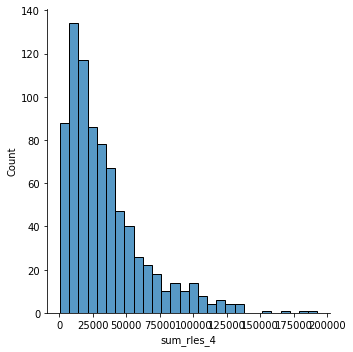

0 percentile value : 491
10 percentile value : 7090
20 percentile value : 11270
30 percentile value : 14671
40 percentile value : 19844
50 percentile value : 25357
60 percentile value : 32663
70 percentile value : 40546
80 percentile value : 52412
90 percentile value : 75187
100 percentile value : 192780


In [ ]:
# Defect class 4

rle_distribution(df, 4)

In [ ]:
# to approximate how much training "masked" data will grow with oversampling
# this is an overestimate since some images have more than 1 class
oversample_multipliers = np.array([3, 4, 1, 2.5])
print('{:.2f}'.format(np.dot(class_counts.freq, oversample_multipliers)))

1.62


## K-Fold setup
The following  function allows the K-Fold data partition to return datasets with or without "unmasked" examples (i.e. examples with or without defects). 

In [ ]:
N_FOLDS = 5
skf = KFold(n_splits=N_FOLDS)
folds ={}

# No. of folds 5 
# skf.split(0,1,2,3,...,19) will run 5 times
for fold, (idxT, idxV) in enumerate(skf.split(np.arange(N_TFRECS_DEFECT))):
    folds.update({fold+1: {'val': idxV, 'train': idxT}})
del fold

def get_fold_file_lists(fold_num, folds=folds, use_unmasked=False):
    fold = folds[fold_num]
    TRAINING_FILENAMES = [TFRECS_DEFECT[i] for i in fold['train']]
    VALIDATION_FILENAMES = [TFRECS_DEFECT[i] for i in fold['val']]

    # images with no defects were completely excluded from validation at training time during segmentation
    if use_unmasked:
        if use_unmasked == True: 
            use_unmasked = ('train', 'val')
        if 'train' in use_unmasked:
            TRAINING_FILENAMES += [TFRECS_NODEFECT[i] for i in fold['train']]
        if 'val' in use_unmasked:
            VALIDATION_FILENAMES += [TFRECS_NODEFECT[i] for i in fold['val']]
    return TRAINING_FILENAMES, VALIDATION_FILENAMES

In [ ]:
folds

{1: {'train': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
  'val': array([0, 1, 2, 3])},
 2: {'train': array([ 0,  1,  2,  3,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
  'val': array([4, 5, 6, 7])},
 3: {'train': array([ 0,  1,  2,  3,  4,  5,  6,  7, 12, 13, 14, 15, 16, 17, 18, 19]),
  'val': array([ 8,  9, 10, 11])},
 4: {'train': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 16, 17, 18, 19]),
  'val': array([12, 13, 14, 15])},
 5: {'train': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
  'val': array([16, 17, 18, 19])}}

## Data Pipeline

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_tfrecord(example, vars = ('image', 'rle', 'label')):
    features = {
        'img_id': tf.io.FixedLenFeature([], tf.string), 
        'image': tf.io.FixedLenFeature([], tf.string), 
        'rle': tf.io.FixedLenFeature([4], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        }
    features = {k: features[k] for k in vars}
    example = tf.io.parse_single_example(example, features)
    return [example[var] for var in features]

# https://slikts.github.io/concurrency-glossary/?id=nondeterministic-vs-deterministic 
        
def load_dataset(filenames, ordered = False):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    if not ordered: 
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False 
        dataset = dataset.with_options(ignore_order)
    return dataset.map(read_tfrecord, num_parallel_calls=AUTO)

In [ ]:
def decode_resize_inputs(inputs, target_size, image_size = IMAGE_SIZE,
                         n_channels = N_CHANNELS, n_classes = N_DEFECT_CLASSES):
    (image_data, rle), args = inputs[:2], inputs[2:]
    image = tf.image.decode_jpeg(image_data, n_channels)
    image = tf.cast(image, tf.float32) / 255.0  
    mask = build_mask_array(rle, image_size, n_classes) 

    if target_size != image_size:
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

    image = tf.reshape(image, [*target_size, n_channels]) 
    mask = tf.reshape(mask, [*target_size, n_classes])
    return (image, mask, *args)

def data_augment(inputs, target_size, 
                 n_channels = N_CHANNELS, n_classes = N_DEFECT_CLASSES, 
                 p1=0.33, p2=0.33):
    
    image, mask, label = inputs

    if tf.random.uniform([]) < p1:
        image, mask = left_right_flip(image, mask)
    
    if tf.random.uniform([]) < p1:
        image, mask = up_down_flip(image, mask)

    if tf.random.uniform([]) < p2: 
        image, mask = random_zoom_out_and_pan(image, target_size, mask, 
                                              n_channels, n_classes)
    elif tf.random.uniform([]) < p2*1.5: 
        image, mask = image_mask_zoom_in(image, mask, target_size, label, 
                                         n_channels, n_classes)
    
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_hue(image, 0.025)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.random_contrast(image, 0.7, 1.4)

    return image, mask, label

def final_reshape(inputs, target_size, target_var, n_channels = N_CHANNELS, 
                  n_classes = N_DEFECT_CLASSES):
    '''
    '''
    image, mask, label = inputs
    image = tf.reshape(image, [*target_size, n_channels]) 

    if target_var == 'mask':
        mask = tf.reshape(mask, [*target_size, n_classes])
        target_var = mask
    elif target_var == 'label': target_var = tf.cast(label, tf.int32)
    else: raise Exception('target_var must be one of \'label\' or \'mask\'')
    return image, target_var

describe_ds = lambda x: print(re.sub('[<>]', '', str(x)))

def print_description(train_ds, val_ds, use_unmasked, p_undersample, n_train, n_valid):
    describe_ds(train_ds)
    approx = 'approx' if p_undersample and p_undersample !=1 and use_unmasked else ''
    print('Unique train examples per epoch {} {}'.format(n_train, approx))
    print('Total valid examples {}'.format(n_valid))
    return None

As observed before, the defects exhibit class imbalance, to compensate for this imbalance, examples with defect types 1, 2 and 3 are over-sampled during training in both, the binary step and the segmentation step. Oversampling is controlled in the Dataset pipeline.

In [ ]:
# randomly filters-out examples with label 0. L is the label, P is the rate to exclude 
# usedto filter only during segmentation training
# For eg if P=0.9, samples with L==0 and random < P will be excluded, rest L==0 and L==1 will be included  

undersample_filter = lambda L, P: False if L == 0 and tf.random.uniform([]) < P else True


def oversample(rles):
    '''
    used together with: 
        dataset.flat_map(lambda *x: tf.data.Dataset.from_tensors(x).repeat(oversample(x[1])))
    to oversample images according to defect class.
    '''
    # b'1 0' denotes empty mask which needs to be excluded in case if any
    # rles[0], rles[1], rles[3] denotes class 1, 2 and 4
    if rles[1] != b'1 0': 
        rep = 4
    elif rles[0] != b'1 0': 
        rep =3
    elif rles[3] != b'1 0' and tf.random.uniform([]) < 0.5: 
        rep =2
    else: 
        rep = 1
    return tf.cast(rep, dtype=tf.int64)

In [ ]:
def get_dataset(filenames, target_size, batch_size, target_var = 'mask',
                augment = False,
                cache   = False,
                repeat  = False, 
                shuffle = False,
                ordered = False, 
                drop_remainder = False,
                p_undersample = False,
                oversample_reps = False):
  
      '''
    returns
    <PrefetchDataset shapes: ((None, 128, 800, 3), (None, 128, 800, 4)), types: (tf.float32, tf.float32)>
    '''

      # returns <ParallelMapDataset shapes: ((), (4,), ()), types: (tf.string, tf.string, tf.int64)>
      dataset = load_dataset(filenames, ordered)

      # returns <FilterDataset shapes: ((), (4,), ()), types: (tf.string, tf.string, tf.int64)>
      if p_undersample:
          dataset = dataset.filter(lambda *data: undersample_filter(data[2], p_undersample))

      # returns <FlatMapDataset shapes: ((), (4,), ()), types: (tf.string, tf.string, tf.int64)>
      if oversample_reps:
          dataset = dataset.flat_map(lambda *data: tf.data.Dataset.from_tensors(
              data).repeat(oversample(data[1])))   # data[1] is the rles
    
      dataset = dataset.map(lambda *data: decode_resize_inputs(data, target_size), AUTO)
      if augment:
          dataset = dataset.map(lambda *data: data_augment(data, target_size), AUTO)
    
      dataset = dataset.map(lambda *data: final_reshape(data, target_size, target_var), AUTO)

      if cache: dataset = dataset.cache()  
      if repeat: dataset = dataset.repeat() 
      if shuffle: dataset = dataset.shuffle(shuffle, reshuffle_each_iteration=True) 

      dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
      dataset = dataset.prefetch(AUTO) 
      return dataset

In [ ]:
def get_datasets(fold_num, target_size, imgs_per_replica, target_var = 'mask', 
             use_unmasked = False, p_undersample = False, 
             cache_val = False, print_descr = True):
    
    TRAINING_FILENAMES, VALIDATION_FILENAMES = get_fold_file_lists(
        fold_num, use_unmasked=use_unmasked)
    
    train_batch_size = imgs_per_replica * N_REPLICAS

    # for steps calculation
    n_train = count_data_items(TRAINING_FILENAMES)
    n_valid = count_data_items(VALIDATION_FILENAMES)

    if p_undersample and use_unmasked and (use_unmasked == True or 'train' in use_unmasked):
        # approximate number of examples given random undersampling, val is never undersampled
        n_train = int(n_train * (1-(p_undersample*class_ratio)/(1+class_ratio)))
        
    train_steps = np.ceil(n_train/train_batch_size).astype(int)
    buffer_size = 4000

    random.shuffle(TRAINING_FILENAMES)
    train_dataset = get_dataset(TRAINING_FILENAMES, target_size, train_batch_size, 
                                target_var, augment = True, repeat = True, 
                                shuffle = buffer_size, drop_remainder=True, 
                                p_undersample = p_undersample,
                                oversample_reps = True)

    if target_var == 'mask':
        val_batch_size = 24 * N_REPLICAS 
        val_ordered = True
    elif target_var == 'label':
        val_batch_size = train_batch_size
        val_ordered = False

    val_steps = np.ceil(n_valid / val_batch_size).astype(int)
    valid_dataset = get_dataset(VALIDATION_FILENAMES, target_size, val_batch_size, 
                                target_var, cache = cache_val, ordered = val_ordered)

    if print_descr:
        print_description(train_dataset, valid_dataset, use_unmasked, 
                          p_undersample, n_train, n_valid)
    steps = {'train': train_steps, 'valid': val_steps}
    datasets = {'train': train_dataset, 'valid': valid_dataset}
    return datasets, steps

In [ ]:
def rle2mask(rle, mask_shape):
    '''
    Converts a run lenght encoding (RLE) into a mask of shape mask_shape
    Args:
        rle: (str or bytestring) run lenght encoding. A series of space
            separated start-pixel run pairs.
        mask_shape: (tuple of 2 ints) the 2D expected shape of the mask
    Returns: mask of shape mask_shape
    '''
    size = tf.math.reduce_prod(mask_shape)

    s = tf.strings.split(rle)
    s = tf.strings.to_number(s, tf.int32)

    starts = s[0::2] - 1
    lens = s[1::2]

    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.int32)

    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)

    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    mask = tf.reshape(mask_flat, (mask_shape[1], mask_shape[0]))
    return tf.transpose(mask)

def build_mask_array(rle, mask_size, n_classes=1):
    '''
    Converts a RLE or a list of RLEs, into an array of
    shape (*mask_size, n_classes)
    '''
    if n_classes == 1:
        mask = rle2mask(rle, mask_size)
        mask = tf.expand_dims(mask, axis=2)
    else:
        mask = [rle2mask(rle[i], mask_size) for i in range(n_classes)]
        mask = tf.stack(mask, axis = -1)
    mask = tf.reshape(mask, (*mask_size, n_classes))
    return mask

## Visualize Masks

In [ ]:
from skimage.segmentation import find_boundaries

def retrieve_examples(dataset, num, idx = None, unbatch = True):
    '''
    idx: (int or list of ints) the index of the features to be extracted from
        the examples.
    '''
    if unbatch: dataset = dataset.unbatch()
    examples = []
    for item in dataset.take(num):
        examples.append(item)
    if idx != None:
        if isinstance(idx, int): examples = [row[idx] for row in examples]
        else:
            examples = [[row[i] for i in range(len(row)) if i in idx] for row in examples]
    return examples


def plot_image_mask(img_mask_tuple, height = 2, cmap = 'bone',
                    mask_rgb = (204, 0, 153), mask_alpha = 0.4):
    '''
    mask_rgb: tuple or list of tuples. tuple(s) contain the rgb values for the
        mask(s). Supply a list of rgb tuples for color coded masks.
    cmap: one from plt.cm, it has an effect only when the image has 1 channel.
    '''
    H, W = img_mask_tuple[0].shape[:2]
    aspect_ratio = W/H
    image = tf.keras.preprocessing.image.array_to_img(img_mask_tuple[0])
    mask = img_mask_tuple[1]
    if mask.ndim == 3 and mask.shape[-1] > 1:
        mask_chans = mask.shape[-1]
        if isinstance(mask_rgb, tuple): mask_rgb = [mask_rgb]*mask_chans
        masks = [(contoured_mask(mask[..., c], mask_rgb[c], alpha = mask_alpha
                                 )) for c in range(mask_chans)]
    else:
        masks = [contoured_mask(mask, mask_rgb, alpha = mask_alpha)]

    width = height*aspect_ratio*2
    width = min(width, 15)
    fig = plt.figure(figsize=(width, height))

    plt.subplot(1,2,1)
    plt.imshow(image, cmap=cmap)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image, cmap=cmap)
    for m in masks:
        plt.imshow(m)
    plt.title('Image + Mask')
    plt.axis('off')
    fig.tight_layout()
    plt.show()
    return None

def contoured_mask(mask, rgb_color = (0, 0, 255), alpha = 0.2):
    rgb_color = np.array(rgb_color)/255
    epsilon = 10e-6
    mask = np.squeeze(mask+epsilon).round().astype(int)
    boundary = find_boundaries(mask).astype(float)
    mask_ = np.zeros((*mask.shape, 4))
    for i, c in enumerate(rgb_color):
        mask_[..., i] = c
    mask_[..., 3] = np.maximum(alpha*mask, boundary)
    return mask_

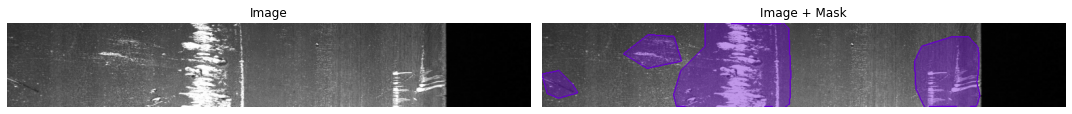

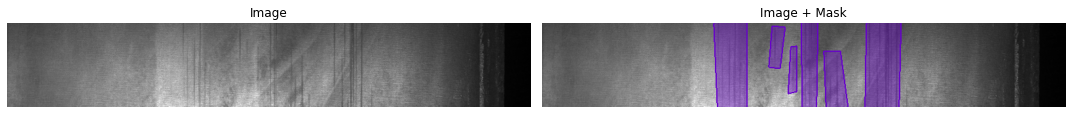

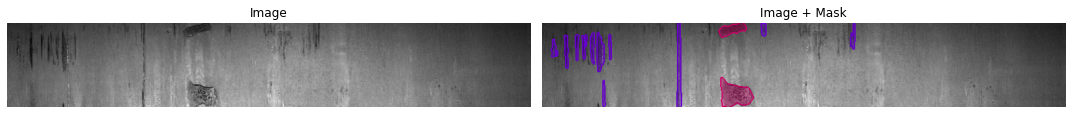

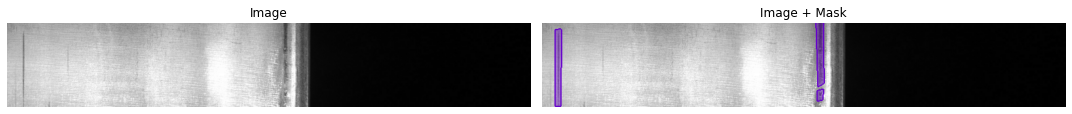

In [ ]:
mask_rgb = [(230, 184, 0), (0, 128, 0), (102, 0, 204), (204, 0, 102)]

num_examples =  4#@param {type:'raw'}

if num_examples:
    temp_dataset = get_dataset(TFRECS_DEFECT, target_size, 1)
    defect_examples = retrieve_examples(temp_dataset, num_examples*5)

    random.shuffle(defect_examples)
    for example in defect_examples[:num_examples]:
        plot_image_mask(example, height=1.8, mask_rgb = mask_rgb)

In [ ]:
def random_zoom_in(image, image_size, n_channels, zoom_range = (0.7, 0.9)):
    '''
    Applies random zoom-in of a random area in the image.
    Args:
        image: an image array
        image_size: a tuple (H, W)
        zoom_range: a tuple of floats (F1, F2) where F1<F2 and both are between 0
            and 1. The range of the zoom-in factor. i.e. a zoom-in factor of 0.9
            will randomly zoom-in an area of H*0.9 x W*0.9 of the original image

    Returns:
        An image with random zoom-in of a random image area
    '''
    h, w = image_size
    aspect_ratio = tf.math.divide(w, h)
    aspect_ratio = tf.cast(aspect_ratio, tf.float32)

    # Determine the random height and width of the area to be zoomed-in.
    random_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    dy = h*random_factor
    dx = dy*aspect_ratio
    dy = tf.cast(dy, tf.int32)
    dx = tf.cast(dx, tf.int32)

    # Determine the random position of the random area within the original image
    max_x = w - dx
    max_y = h - dy
    x = tf.random.uniform([], 0, max_x, dtype = tf.int32)
    y = tf.random.uniform([], 0, max_y, dtype = tf.int32)

    # Crop + Resize -> Zoom-in
    cropped_img = tf.image.crop_to_bounding_box(image, y, x, dy, dx)
    zoomed_img = tf.image.resize(cropped_img, size = image_size)
    zoomed_img = tf.reshape(zoomed_img, (*image_size, n_channels))
    return zoomed_img

def random_zoom_out_and_pan(image, image_size, mask = None,
                            n_channels = 3, n_classes = 1,
                            zoom_range = (0.7, 0.9)):
    '''
    Applies random zoom out with random pan to an image.
    Args:
        image: a 3D image array
        image_size: a tuple (H, W). Height and width of both, the mask and image
        mask: a 3D mask array to apply the same transform as the image
        n_channels: (int) number of image channels typically 1 or 3
        n_classes: (int) one of {1, 3, 4} number of masks in the mask array. i.e
            the number of channels in the mask
        zoom_range: a tuple of floats (F1, F2) where F1<F2 and both are between
            0 and 1. The range of zoom-out factor.
    Returns:
        An image (and mask if specified) with random zoom-out + pan applied of
        image_size size.
    '''
    # Determine the random zoomed-out size
    random_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])
    height_width = tf.constant(image_size)
    dim_deltas = tf.cast(height_width, dtype=tf.float32)*(1-random_factor)
    dim_deltas = tf.cast(dim_deltas, dtype = tf.int32)
    zoomed_size = height_width - dim_deltas

    # Determine the random padding for each side to create random pan
    paddings_c = tf.constant([0,0])
    pad_top = tf.random.uniform([], 0, dim_deltas[0], dtype = tf.int32)
    pad_left = tf.random.uniform([], 0, dim_deltas[1], dtype = tf.int32)
    pad_bottom = dim_deltas[0] - pad_top
    pad_right = dim_deltas[1] - pad_left
    aug_paddings = tf.stack([[pad_top, pad_bottom], [pad_left, pad_right], paddings_c], axis=0)

    # apply zoom-out and panning to image, then reshape.
    zoomed_img = tf.image.resize(image, zoomed_size)
    zoomed_img = tf.pad(zoomed_img, aug_paddings)
    zoomed_img = tf.reshape(zoomed_img, (*image_size, n_channels))

    if mask != None:
        zoomed_mask = tf.image.resize(mask, zoomed_size)
        zoomed_mask = tf.pad(zoomed_mask, aug_paddings)
        zoomed_mask = tf.reshape(zoomed_mask, (*image_size, n_classes))
        return zoomed_img, zoomed_mask
    else: return zoomed_img

def left_right_flip(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def up_down_flip(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def diag_flip(image, mask):
    image, mask = left_right_flip(image, mask)
    image, mask = up_down_flip(image, mask)
    return image, mask

def image_mask_zoom_in(image, mask, image_size, label = None,
                               n_channels = 3, n_classes = 1,
                               zoom_range = (0.1, 0.4)):
    '''
    Applies random zoom-in to a random area in the image and the mask
    Args:
        image: a 3D image array of size (H, W, C), C is one of {1, 3, 4}
        mask: a 3D mask array of size (H, W, C), C is one of {1, 3, 4}
        image_size: a tuple (H, W)
        label: one of {None, 0, 1}, provide if available to reduce computations,
            0 if the mask is empty, 1 otherwise.
        n_channels: (int) number of image channels typically 1 or 3
        n_classes: (int) one of {1, 3, 4} number of masks in the mask array.
            i.e the number of channels of the mask. For implementing n_classes > 4, see
            stackoverflow.com/questions/43814367/resize-3d-data-in-tensorflow-like-tf-image-resize-images
        zoom_range: a tuple of floats (F1, F2) where F1<F2 and both are between 0
            and 1. The range of the zoom-in factor. A larger zoom-in factor will
            yield a more intense zoom-in.
    Returns:
        an image and mask tuple with mask preserving zoom-in applied to both
    '''
    if label != 0 and tf.math.reduce_sum(tf.round(mask)) > 0:

        # transform to prevent left-top bias
        P = tf.random.uniform([], dtype='float32')
        if P > 0.75: image, mask = left_right_flip(image, mask)
        elif P > 0.50: image, mask = up_down_flip(image, mask)
        elif P > 0.25: image, mask = diag_flip(image, mask)

        h, w = image_size
        aspect_ratio = tf.cast(tf.math.divide(w, h), tf.float32)

        if n_classes > 1: mask_ = tf.math.reduce_sum(tf.round(mask), axis = 2)
        else: mask_ = tf.round(mask)

        # locate top-left and bottom-right points from the mask, then create new
        # coordinates that cuts the distance between the mask and the edges of the
        # image by the random_factor.
        locations = tf.transpose(tf.where(mask_))
        locations = tf.cast(locations, dtype=tf.float32)

        random_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])

        x1 = tf.cast(random_factor*tf.math.reduce_min(locations[1]), tf.int32)
        y1 = tf.cast(random_factor*tf.math.reduce_min(locations[0]), tf.int32)

        x2 = tf.math.reduce_max(locations[1])
        y2 = tf.math.reduce_max(locations[0])
        x2 = tf.cast(x2 + (w - x2)*(1-random_factor), tf.int32)
        y2 = tf.cast(y2 + (h - y2)*(1-random_factor) , tf.int32)

        # calculate runs (distances), required by tf.image.crop_to_bounding_box()
        dy = tf.cast(y2 - y1, tf.float32)
        dx = tf.cast(x2 - x1, tf.float32)

        # fix to original aspect ratio, make sure the crop is within the orig
        # image margins
        if tf.math.divide(dx, dy) > aspect_ratio: dx = dy*aspect_ratio
        else: dy = tf.math.divide(dx, aspect_ratio)

        dy = tf.cast(dy, tf.int32)
        dx = tf.cast(dx, tf.int32)

        # fail-safe
        dy = tf.math.maximum(dy, 1)
        dx = tf.math.maximum(dx, 1)
        dy = tf.math.minimum(dy, h-y1)
        dx = tf.math.minimum(dx, w-x1)

        # crop, resize
        image = tf.image.crop_to_bounding_box(image, y1, x1, dy, dx)
        image = tf.image.resize(image, size = image_size)

        mask = tf.image.crop_to_bounding_box(mask, y1, x1, dy, dx)
        mask = tf.image.resize(mask, size = image_size)

        # revert flip transforms
        if P > 0.75: image, mask = left_right_flip(image, mask)
        elif P > 0.50: image, mask = up_down_flip(image, mask)
        elif P > 0.25: image, mask = diag_flip(image, mask)

        mask = tf.reshape(mask, (*image_size, n_classes))

    else:
        image = random_zoom_in(image, image_size, n_channels, zoom_range = (0.7, 0.9))

    image = tf.reshape(image, (*image_size, n_channels))
    return image, mask

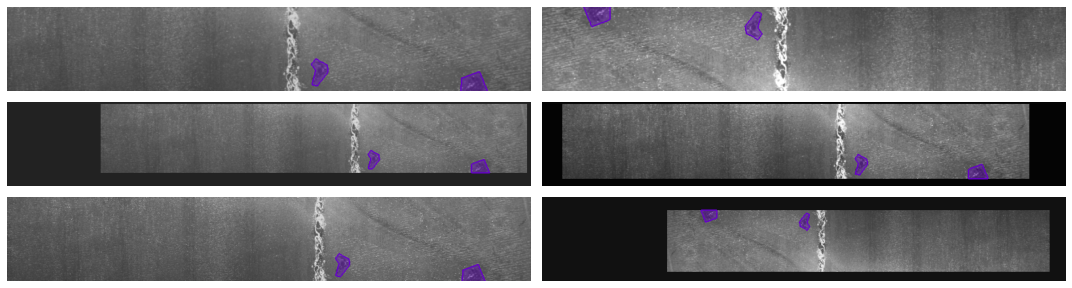

In [ ]:
if num_examples:
    n_rows, n_cols = 3, 2
    example = defect_examples[num_examples]
    example = (*example, 1) # add the label (required by data_augment)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 1.4*n_rows))
    for c in range(n_rows*n_cols):   
        image, mask, _ = data_augment(example, target_size, p1=.5, p2=0.5)
        masks = [(contoured_mask(mask[..., c], mask_rgb[c], alpha = 0.4)) for c in range(4)]
        ax = fig.axes[c]
        # np.clip to supress warning. vals outside ranges b/c random brightness, contrast augmentations
        ax.imshow(np.clip(image, 0, 1)) 
        for m in masks:
            ax.imshow(m)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [ ]:
TRAINING = True         #@param {type: 'boolean'}
ADD_PRETRAINED = False   #@param {type: 'boolean'}
PROJECT_DIR = 'drive/MyDrive/SSDD/'
weights_dir = PROJECT_DIR + 'weights/'
!mkdir -p {weights_dir}  # mount drive 

In [ ]:
#@markdown Importing Trained Weights
zip_dest = PROJECT_DIR + 'severstal-fold-1-weights.zip'
if ADD_PRETRAINED: 
    if not os.path.isfile(zip_dest):
        !gdown https://drive.google.com/uc?id=12BWVtZqg0EtWq0J2329ggyR7eK35bycV -O {zip_dest}
    !unzip -qn {zip_dest} -d {weights_dir} 

Downloading...
From: https://drive.google.com/uc?id=12BWVtZqg0EtWq0J2329ggyR7eK35bycV
To: /content/drive/SSDD/severstal-fold-1-weights.zip
100% 525M/525M [00:04<00:00, 115MB/s]


In [ ]:
# Get names of saved weights (if any) in main weights directory
!mkdir -p {weights_dir}discarded/
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

weights_metrics = {}
weights_names = {}

for w in saved_weights:

    # ['efficientnet-b5-unet-f3', '128x800', 'adice', '65687.h5']
    prefix, sz, _ , metric = w.split('_')

    prefix = '{}_{}'.format(prefix, sz)

    metric_float = float(metric.split('.')[0])*10e-6

    if not prefix in weights_metrics:
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    elif metric_float > weights_metrics[prefix]:
        !mv {weights_dir}{weights_names[prefix]} {weights_dir}discarded/
        weights_metrics[prefix] = metric_float
        weights_names[prefix] = w
    else: 
        !mv {weights_dir}{w} {weights_dir}discarded/

def check_and_save(history, model, fold_num, img_size, metric, metric_abbr = 'acc',
                   current_wname = 'weights.h5', weights_dir=weights_dir):
    current_metric = max(history.history[metric])
    size_str = str(img_size[0]) + 'x' + str(img_size[1])
    prefix = '{}-f{}_{}'.format(model.name.lower(), fold_num, size_str)
    metric_str = str(current_metric*10e4)[:5]
    weights_name = '{}_{}_{}.h5'.format(prefix, metric_abbr, metric_str)
    if not prefix in weights_metrics or current_metric >= weights_metrics[prefix]: 
        weights_names[prefix] = weights_name
        if prefix in weights_metrics:
            !mv {weights_dir}{prefix}* {weights_dir}discarded/
        !cp {current_wname} {weights_dir}{weights_name}
        weights_metrics[prefix] = current_metric
        saved_weights.append(weights_name)
    return None

In [ ]:
class performance_monitor(tf.keras.callbacks.Callback):
    '''
    Prints out information when the value of the `watch` metric has improved.
    freq: (None or int), if int, the frequency (in epochs) to print out all
        metrics regardless of improvements.
    '''
    def __init__(self, watch='val_loss', mode = 'min', freq=None):
        self.freq = freq
        self.watch = watch
        self.mode = mode

    def on_train_begin(self, logs=None):
        if self.mode == 'min':
            self.best = np.Inf
            self.compare = tf.math.less
        else:
            self.best = -np.Inf
            self.compare = tf.math.greater
        self.best_logs = None
        self.best_epoch = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.watch)
        if self.compare(current, self.best):
            print('New best at Epoch {:03d} {} improved from {:.4f} to {:.4f}'.format(
                epoch+1, self.watch, self.best, current))
            self.best = current
            self.best_logs = logs
            self.best_epoch = epoch

        if self.freq:
            if (epoch+1) % self.freq == 0:
                items = ['{}: {:.4f}'.format(i[0], i[1]) for i in logs.items()]
                print('Epoch: {:03d}'.format(epoch+1), *items)

    def on_train_end(self, logs=None):
        items = ['{}: {:.5f}'.format(i[0], i[1]) for i in self.best_logs.items()]
        print('\nBest at Epoch: {:03d}'.format(self.best_epoch+1), *items[:-1])

## Learning Rate Scheduler

In [ ]:
# https://medium.com/@bechr7/learning-rate-scheduling-with-callbacks-in-tensorflow-e2ba83647013

lr_default_params = {
    'lr_start': 3e-4,
    'lr_max': 3e-4,
    'lr_min': 1e-6,
    'lr_num_ramp_eps': 3,
    'lr_sustain_eps': 4,
    'lr_decay': 0.8}

lr_default_params =  list(lr_default_params.values())

def lrfn(epoch, lr_params = lr_default_params):
    lr_start, lr_max, lr_min, lr_ramp_ep, lr_sus_ep, lr_decay = lr_params
    if epoch < lr_ramp_ep: lr = (lr_max - lr_start)/lr_ramp_ep*epoch + lr_start
    elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
    else: lr = (lr_max - lr_min)*lr_decay**(epoch-lr_ramp_ep - lr_sus_ep)+lr_min
    return lr

def lr_schedule_builder(params=lr_default_params):
    lrsched = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: lrfn(epoch, params), verbose=False)
    return lrsched

def plot_lr_timeline(lr_params, num_epochs = 25, show_list=False):
    '''
    Plots the learning rate timeline of for the lrfn() learning rate function
    '''
    lr_timeline = [lrfn(i, lr_params) for i in range(num_epochs)]
    t = [i+1 for i in range(num_epochs)]
    plt.figure(figsize=(max(10, int(num_epochs/3)), 4))
    plt.plot(t, lr_timeline)
    plt.xticks(t)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Epoch')
    idx = np.argmax(lr_params[:3])
    plt.ylim(0, lr_params[idx]*1.1)
    plt.title('Learning Rate Timeline')
    plt.show()
    if show_list: print(lr_timeline)

## Training - Binary Classification
This step consists of EfficientNet (Tan & Le 2020) based classifiers versions B0-B5. The classifiers were selected according to their out-of-fold (i.e. fold validation) performance. The metric optimized for this task was accuracy on the full out-of-fold data for each fold.

In [ ]:
EPOCHS = 20
metric_monitor = performance_monitor('val_accuracy', 'max')
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
hline = u'\u2500'*83

imgs_per_replica = 32
lr_params =  [3e-3,  3e-3,  1e-6, 3, 4, 8e-1]
lr_sched = lr_schedule_builder(lr_params)
if TRAINING:  
    !pip -q install tensorflow_addons >/dev/null
    import tensorflow_addons as tfa
    radam = tfa.optimizers.RectifiedAdam()

In [ ]:
# Specify fold and model version for training session

folds_to_train = [3] 
efficientnet_versions = [1, 2]

In [ ]:
pip install -U efficientnet

     |████████████████████████████████| 50 kB 2.9 MB/s 


In [ ]:
import tensorflow as tf
import efficientnet.tfkeras as efn

cnn_dict = {
    'efficientnetb0': (efn.EfficientNetB0),
    'efficientnetb1': (efn.EfficientNetB1),
    'efficientnetb2': (efn.EfficientNetB2),
    'efficientnetb3': (efn.EfficientNetB3),
    'efficientnetb4': (efn.EfficientNetB4),
    'efficientnetb5': (efn.EfficientNetB5),
    'efficientnetb6': (efn.EfficientNetB6),
    'efficientnetb7': (efn.EfficientNetB7),
    # 'efficientnetL2': (efn.EfficientNetL2),
    'resnet50':       (tf.keras.applications.ResNet50),
    'resnet101':      (tf.keras.applications.ResNet101),
    'resnet152':      (tf.keras.applications.ResNet152)
    }

def get_cnn_func(cnn_name):
    if isinstance(cnn_name, int):
        if cnn_name < 8:
            cnn_key = 'efficientnetb{}'.format(cnn_name)
        else: cnn_key = 'resnet{}'.format(cnn_name)

    else: cnn_key = re.sub('[\W_]', '', cnn_name).lower()
    return cnn_dict[cnn_key]


def build_classifier(base_name, n_classes, input_shape = (None, None, 3),
                     weights ='imagenet', head_dropout=None, name_suffix=''):
    '''
    Assembles an CNN classifier
    Args:
        base_name: (str) one of 'efficientnetb0' to 'efficientnetb7' or
            'resnet50' to 'resnet152'.
        n_classes: (int) number of classes. i.e. number of filters in the output layer.
        weights: pretrained weights. one of None, 'imagenet',
            'noisy-student' or the path to the weights file to be loaded.
            Note: 'noisy-student' is only available for efficientnet classifiers.
        head_dropout: None or float. If float, the dropout rate before the last
            dense layer.
        name_suffix: (str) string to add to the model name
    '''
    CNN = get_cnn_func(base_name)
    base = CNN(input_shape=input_shape, weights=weights, include_top=False)

    x = L.GlobalAveragePooling2D()(base.output)
    if head_dropout:
        x = L.Dropout(head_dropout)(x)
    x = L.Dense(n_classes, activation='sigmoid', name='output_layer')(x)
    model = tf.keras.Model(inputs=base.input, outputs=x,
                           name='{}{}'.format(base.name.title(), name_suffix))
    return model


In [ ]:
def config_checkpoint(filepath = 'weights.h5', monitor ='val_loss', mode = 'min', verbose=0):
    # configures the training checkpoint to save best weights
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        monitor = monitor,
        mode = mode,
        save_best_only = True,
        save_weights_only=True,
        verbose = verbose)
    return checkpoint

def time_passed(start_time):
  secs = time() - start_time
  if secs < 3600: elapsed = strftime("%M:%S", gmtime(secs))
  elif secs < 3600*24: elapsed = strftime("%H:%M:%S", gmtime(secs))
  else: elapsed = '{:.0f} seconds'.format(secs)
  return elapsed

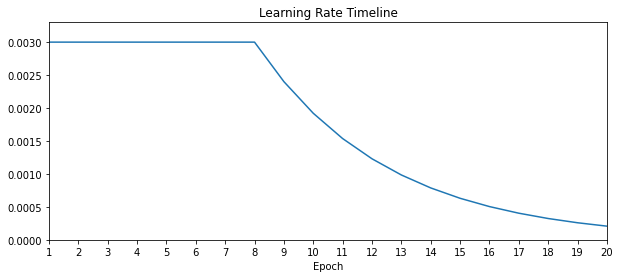

In [ ]:
plot_lr_timeline(lr_params, num_epochs = 20, show_list=False)

**For the binary model**: <br>
- All the available data is used for training and validation ( select `use_unmasked = True` and `p_undersample = None`).

In [ ]:
if TRAINING:
    for training_fold in folds_to_train:
        print(hline +'\nDataset for FOLD {} with image size {}\n'.format(
            training_fold, target_size) + hline)
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 
                                    'label', use_unmasked = True)
        train_steps = int(steps['train']*1.25) # steps were added due to over-sampling

        for efn_ver in efficientnet_versions:
            base_model = 'EfficientNet-B{}'.format(efn_ver)
            print(hline +'\nTraining {} on FOLD {} with image size {}\n'.format(
                base_model, training_fold, target_size) + hline)

            with strategy.scope(): 
                model = build_classifier(base_model, n_classes = 1, input_shape = INPUT_SHAPE, 
                                        weights = 'imagenet', name_suffix='-bin')
                model.compile(optimizer=radam, loss=loss, metrics=['accuracy', 'AUC']) 

            train_begin = time()
            checkpoint = config_checkpoint(monitor ='val_accuracy', mode = 'max')
            history = model.fit(datasets['train'], steps_per_epoch= train_steps,
                                epochs= EPOCHS, verbose=0, 
                                callbacks=[lr_sched, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])
            
            check_and_save(history, model, training_fold, target_size, 'val_accuracy', 'acc')
            print(hline+'\nTime to train {} epochs: {}'.format(EPOCHS, time_passed(train_begin)))
            del model
            K.clear_session()

    del training_fold, datasets, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
Dataset for FOLD 3 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((256, 128, 800, 3), (256,)), types: (tf.float32, tf.int32)
Unique train examples per epoch 10056 
Total valid examples 2512
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B1 on FOLD 3 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
27172864/27164032 [==============================] - 0s 0us/step
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


New best at Epoch 001 val_accuracy improved from -inf to 0.8181
New best at Epoch 002 val_accuracy improved from 0.8181 to 0.8388
New best at Epoch 003 val_accuracy improved from 0.8388 to 0.9244
New best at Epoch 005 val_accuracy improved from 0.9244 to 0.9467
New best at Epoch 007 val_accuracy improved from 0.9467 to 0.9514
New best at Epoch 009 val_accuracy improved from 0.9514 to 0.9717
New best at Epoch 010 val_accuracy improved from 0.9717 to 0.9777
New best at Epoch 013 val_accuracy improved from 0.9777 to 0.9789
New best at Epoch 015 val_accuracy improved from 0.9789 to 0.9821

Best at Epoch: 015 loss: 0.13251 accuracy: 0.99336 auc: 0.99973 val_loss: 0.15885 val_accuracy: 0.98209 val_auc: 0.99501
───────────────────────────────────────────────────────────────────────────────────
Time to train 20 epochs: 12:59
───────────────────────────────────────────────────────────────────────────────────
Training EfficientNet-B2 on FOLD 3 with image size (128, 800)
─────────────────────────

## Segmentation Metrics

In [ ]:
# https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    den = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth
    dice = (2. * intersection + smooth)/den
    return dice

def dice_avg(y_true, y_pred):
    '''
    Calculates the image-wise average dice coefficient in a batch of masks.
    args:
        y_true: tensor of shape (N, H, W, C), where N is the batch size and C
                is the number of classes (i.e. num of channels of the mask)
        y_pred: tensor of shape y_true.shape
    Returns the average dice coefficient accross images in the batch.
    '''
    img_dice = tf.vectorized_map(lambda args: dice_coef(*args), [y_true, y_pred])
    img_dice_avg = tf.math.reduce_mean(img_dice)
    return img_dice_avg

def channel_avg_dice(y_true, y_pred, smooth = 1.):
    '''
    Calculates the channel-wise average dice coefficient in a batch of masks.
    args:
        y_true: tensor of shape (N, H, W, C), where N is the batch size and C
                is the number of classes (i.e. num of channels of the mask)
        y_pred: tensor of shape y_true.shape
    Returns the average dice coefficient accross all channels.
    '''
    # Stacking the channels along the 1st dimension.
    # They will be ordered by channel_num then by image i.e. y_true[2] will be
    # the channel 0 of image 2
    y_true = tf.concat(tf.unstack(y_true, axis=-1), axis=0)
    y_pred = tf.concat(tf.unstack(y_pred, axis=-1), axis=0)

    channel_dice = tf.vectorized_map(lambda args: dice_coef(*args, smooth),
                                     [y_true, y_pred])
    channel_dice_avg = tf.math.reduce_mean(channel_dice)
    return channel_dice_avg

def dice_loss(y_true, y_pred, smooth = 1.):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = y_true_flat * y_pred_flat
    den = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth
    score = (2. * tf.reduce_sum(intersection) + smooth)/den
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [ ]:
if TRAINING:  
    !pip install -qU segmentation-models
    os.environ['SM_FRAMEWORK'] = 'tf.keras'
    from segmentation_models import losses
    focal_dice = losses.binary_focal_dice_loss 

def dice_coefficient(y_true, y_pred, smooth=1.):
    # compatible with evaluation in prediction loop
    smooth = tf.constant(smooth)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    denom = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth
    dice = (tf.constant(2.) * intersection + smooth)/denom
    return dice

Segmentation Models: using `tf.keras` framework.


In [ ]:
# redefining existing metrics to reduce verbosity
def dice(y, p): 
  return dice_coef(y, p)

def adice(y, p): 
  return dice_avg(y, p)

def chdice(y, p): 
  return channel_avg_dice(y, p)

In [ ]:
EPOCHS_1 = 20
EPOCHS_2 = 15
EPOCHS_TOT = EPOCHS_1 + EPOCHS_2

lr_params_1 = [3e-3, 3e-3, 1e-6, 2, 4, 8e-1]
lr_sched_1 = lr_schedule_builder(lr_params_1)

lr_params_2 = [2e-4, 2e-4, 1e-6, 0, EPOCHS_1, 8e-1]
lr_sched_2 = lr_schedule_builder(lr_params_2) 

nadam = tf.keras.optimizers.Nadam()
adam = tf.keras.optimizers.Adam()

metrics = [dice, adice, chdice]

imgs_per_replica = 8 
metric_monitor = performance_monitor('val_chdice', 'max')

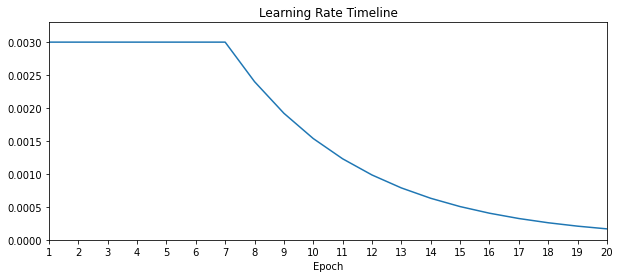

In [ ]:
plot_lr_timeline(lr_params_1, num_epochs = 20, show_list=False)

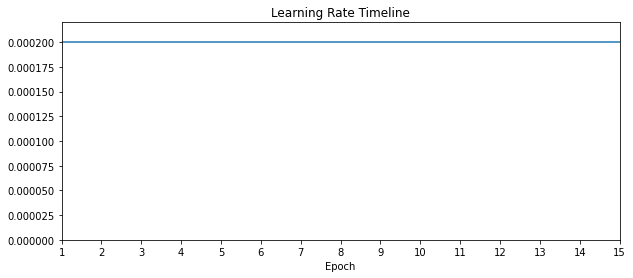

In [ ]:
plot_lr_timeline(lr_params_2, num_epochs = 15, show_list=False)

## Training - Semantic Segmentation

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn
import re

cnn_dict = {
    'efficientnetb0': (efn.EfficientNetB0),
    'efficientnetb1': (efn.EfficientNetB1),
    'efficientnetb2': (efn.EfficientNetB2),
    'efficientnetb3': (efn.EfficientNetB3),
    'efficientnetb4': (efn.EfficientNetB4),
    'efficientnetb5': (efn.EfficientNetB5),
    'efficientnetb6': (efn.EfficientNetB6),
    'efficientnetb7': (efn.EfficientNetB7),
    'resnet50':       (tf.keras.applications.ResNet50),
    'resnet101':      (tf.keras.applications.ResNet101),
    'resnet152':      (tf.keras.applications.ResNet152)
    }

def get_cnn_func(cnn_name):
    if isinstance(cnn_name, int):
        if cnn_name < 8:
            cnn_key = 'efficientnetb{}'.format(cnn_name)
        else: cnn_key = 'resnet{}'.format(cnn_name)

    else: cnn_key = re.sub('[\W_]', '', cnn_name).lower()
    return cnn_dict[cnn_key]


def block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)
    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))

def get_layer_number(model, layer_name):
    """
    Finds layer in tf.keras model by name
    Args: model: tf.keras `Model`
          layer_name: str, name of layer
    Returns: index of layer
    Raises: ValueError: if model does not contain layer with such name
    """
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))

unet_skip_connections_dict = {
    'efficientnet': ('block6a_expand_activation', 'block4a_expand_activation',
                     'block3a_expand_activation', 'block2a_expand_activation'),
    'resnet':       ('conv4_block6_out', 'conv3_block4_out', 'conv2_block3_out',
                     'conv1_relu')
    }

# Unet Blocks
def ConvNRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = L.Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = L.BatchNormalization(name=bn_name)(x)
        x = L.Activation('relu', name=relu_name)(x)
        #x = L.LeakyReLU(alpha=0.1,  name=relu_name)(x)
        return x
    return layer

def DecoderUpsample2DBlock(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name = block_names(stage)
        x = L.UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)
        if skip is not None:
            x = L.Concatenate()([x, skip])

        x = ConvNRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)
        x = ConvNRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
        return x
    return layer

def DecoderTranspose2DBlock(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):
  
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name = block_names(stage)
        x = L.Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
  
        if use_batchnorm:
            x = L.BatchNormalization(name=bn_name+'1')(x)
  
        x = L.Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = L.Concatenate()([x, skip])

        x = ConvNRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
        return x
    return layer

# Unet Model
def unet_model(backbone, num_classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               block_type='transpose',
               activation='sigmoid',
               use_batchnorm=True):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = DecoderTranspose2DBlock
    elif block_type == 'upsampling':
        up_block = DecoderUpsample2DBlock
    else: raise Exception('block_type must be one of \'transpose\' or \'upsampling\'')

    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])

    for i in range(n_upsample_blocks):   
        skip_connection = None    

        if i < len(skip_connection_idx):
            skip_connection = backbone.layers[skip_connection_idx[i]].output

        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], i, upsample_rate=upsample_rate,
                     skip=skip_connection, use_batchnorm=use_batchnorm)(x)

    x = L.Conv2D(num_classes, (3,3), padding='same', name='final_conv')(x)
    x = L.Activation(activation, name=activation)(x)

    model = tf.keras.Model(input, x, name='{}-Unet'.format(backbone.name.title()))
    return model

# Unet Builder (for matching and unmatching weights)
def unet(backbone_name, num_classes, input_shape=(None, None, 3),
         skip_connection_layers='default',
         decoder_filters=(256,128,64,32,16),
         upsample_rates=(2,2,2,2,2),
         n_upsample_blocks=5,
         block_type='transpose',
         activation='sigmoid',
         use_batchnorm=True,
         freeze_backbone = False,
         weights='imagenet',
         weights_by_name = False):

    if not weights_by_name: 
        cnn_weights = weights
    else: 
        cnn_weights = None

    CNN = get_cnn_func(backbone_name)
    backbone = CNN(include_top=False, weights=cnn_weights, input_shape=input_shape)
    
    if weights_by_name:
        backbone.load_weights(weights, by_name=True)

    backbone.trainable = not freeze_backbone

    if skip_connection_layers == 'default':
        if 'efficientnet' in backbone.name.lower():
            skips_dict_key = 'efficientnet'
        elif 'resnet' in backbone.name.lower():
            skips_dict_key = 'resnet'
        skip_connection_layers = unet_skip_connections_dict[skips_dict_key]

    model = unet_model(backbone, num_classes, skip_connection_layers,
                       decoder_filters, upsample_rates, n_upsample_blocks,
                       block_type, activation, use_batchnorm)
    return model



**For the segmentation model** <br>
- Non-defect data is used only for training (`use_unmasked = 'train'`) and exclude all non-defect data for validation. 
- Undersample non-defect data for training using the arg `p_undersample` in the dataset pipeline. 
- For validation, during training, use a constant batch size across specifications. This will make the Dice metric more consistent and comparable since the metric is affected by batch size.
- Because of the way Dice coefficient is calculated during training, examples in the last validation batch might have a disproportionate effect on the metric. To minimize this issue:
    - Avoid using a repeated validation dataset during training; it slows down training considerably. 
    - Instead, use a finite validation dataset and optimize the constant batch size to:
        - Minimize the oversized influence of images in the last batch (if kept). This is the method chosen below. 24 images per replica, for a batch size of 192, minimizes oversized influence for all 5 folds. 

In [ ]:
folds_to_train = [3] 
efficientnet_versions = [1]
#resnet_versions = [50]

In [ ]:
if TRAINING:  
    for training_fold in folds_to_train:
        print(hline +'\nDataset for FOLD {} with image size {}\n'.format(
            training_fold, target_size) + hline)
        
        datasets, steps = get_datasets(training_fold, target_size, imgs_per_replica, 'mask', 
                                    use_unmasked = 'train', p_undersample = 0.90)
        
        train_steps = int(steps['train']*1.30) # steps were added due to over-sampling

        for ver in efficientnet_versions:
        #for ver in resnet_versions:
            base_name = 'EfficientNet-B{}'.format(ver)
            #base_name = 'ResNet{}'.format(ver)
            print(hline +'\nTraining Unet with {} base on FOLD {} with image size {}\n'.format(
                base_name, training_fold, target_size) + hline)
            with strategy.scope(): 
                model = unet(base_name, num_classes=N_DEFECT_CLASSES, input_shape=INPUT_SHAPE)
                model.compile(optimizer=nadam, loss=focal_dice, metrics=metrics) 

            train_begin = time()
            checkpoint = config_checkpoint(monitor='val_adice', mode='max')
            history = model.fit(datasets['train'], steps_per_epoch=train_steps,
                                epochs= EPOCHS_1, verbose=0, 
                                callbacks=[lr_sched_1, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])
            
            print('\nFine tuning with Dice Loss and Adam')
            with strategy.scope():
                model.compile(optimizer=adam, loss=dice_loss, metrics=metrics) 

            history = model.fit(datasets['train'], steps_per_epoch=train_steps,
                                epochs=EPOCHS_TOT, initial_epoch=EPOCHS_1, verbose=0, 
                                callbacks=[lr_sched_2, metric_monitor, checkpoint],
                                validation_data=datasets['valid'])

            check_and_save(history, model, training_fold, target_size, 'val_adice', 'adice')
            print(hline+'\nTime to train {} epochs: {}'.format(EPOCHS_TOT, time_passed(train_begin)))

            del model
            K.clear_session()

    del training_fold, datasets, imgs_per_replica, history

───────────────────────────────────────────────────────────────────────────────────
Dataset for FOLD 3 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
PrefetchDataset shapes: ((64, 128, 800, 3), (64, 128, 800, 4)), types: (tf.float32, tf.float32)
Unique train examples per epoch 5805 approx
Total valid examples 1332
───────────────────────────────────────────────────────────────────────────────────
Training Unet with EfficientNet-B1 base on FOLD 3 with image size (128, 800)
───────────────────────────────────────────────────────────────────────────────────
New best at Epoch 001 val_chdice improved from -inf to 0.0375
New best at Epoch 002 val_chdice improved from 0.0375 to 0.0873
New best at Epoch 003 val_chdice improved from 0.0873 to 0.1952
New best at Epoch 004 val_chdice improved from 0.1952 to 0.4143
New best at Epoch 005 val_chdice improved from 0.4143 to 0.5277
New best at Epoch 008 val_chdice improved from 0.5277 to 

In [ ]:
tf.io.gfile.glob(weights_dir+'*.h5')

['drive/MyDrive/SSDD/weights/efficientnet-b3-bin-f3_128x800_acc_98328.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b5-bin-f3_128x800_acc_97492.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b3-unet-f3_128x800_adice_68573.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b5-unet-f3_128x800_adice_65687.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b4-bin-f3_128x800_acc_98407.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b3-unet-f4_128x800_adice_68394.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b3-unet-f1_128x800_adice_69674.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b3-unet-f2_128x800_adice_68550.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b3-unet-f5_128x800_adice_68397.h5',
 'drive/MyDrive/SSDD/weights/resnet-50-unet-f3_128x800_adice_62170.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b2-unet-f3_128x800_adice_68229.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b4-unet-f3_128x800_adice_65734.h5',
 'drive/MyDrive/SSDD/weights/efficientnet-b1-bin-f3_128x800_acc_98208.h5',
 'dr

## Saved models

In [ ]:
# Get names of saved weights (if any) in main weights directory
!mkdir -p {weights_dir}discarded/
saved_weights = [w.split('/')[-1] for w in tf.io.gfile.glob(weights_dir+'*.h5')]

In [ ]:
def create_df_row(w):
    # w: (str) is the filename of the saved weights
    base, size, _, score = w.split('_')
    key_id = '{}_{}'.format(base, size)
    score = float(score.split('.')[0])*10e-6
    size = eval(size.replace('x', ', '))
    base, efn_ver, model_type, fold_num = base.split('-')
    metric = 'accuracy' if 'bin' in model_type else 'dice'
    model_type = 'binary' if 'bin' in model_type else 'segmentation'
    backbone, fold_num = base+efn_ver, int(fold_num[1])
    return [key_id, backbone, fold_num, size, score, metric, model_type, w]


In [ ]:
col_names = ['key', 'base', 'fold', 'size', 'score', 'metric', 'model_type', 'filename']
bin_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
seg_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 

weights_df = pd.DataFrame(bin_rows + seg_rows, columns = col_names)
display(weights_df[col_names[:7]])

,key,base,fold,size,score,metric,model_type
0,efficientnet-b3-bin-f3_128x800,efficientnetb3,3,"(128, 800)",0.98328,accuracy,binary
1,efficientnet-b5-bin-f3_128x800,efficientnetb5,3,"(128, 800)",0.97492,accuracy,binary
2,efficientnet-b4-bin-f3_128x800,efficientnetb4,3,"(128, 800)",0.98407,accuracy,binary
3,efficientnet-b1-bin-f3_128x800,efficientnetb1,3,"(128, 800)",0.98208,accuracy,binary
4,efficientnet-b2-bin-f3_128x800,efficientnetb2,3,"(128, 800)",0.97292,accuracy,binary
5,efficientnet-b3-unet-f3_128x800,efficientnetb3,3,"(128, 800)",0.68573,dice,segmentation
6,efficientnet-b5-unet-f3_128x800,efficientnetb5,3,"(128, 800)",0.65687,dice,segmentation
7,efficientnet-b3-unet-f4_128x800,efficientnetb3,4,"(128, 800)",0.68394,dice,segmentation
8,efficientnet-b3-unet-f1_128x800,efficientnetb3,1,"(128, 800)",0.69674,dice,segmentation
9,efficientnet-b3-unet-f2_128x800,efficientnetb3,2,"(128, 800)",0.68550,dice,segmentation


In [ ]:
def get_best_weights(df, n_per_fold = 5, sort_by_col = 'score', 
                     group_by_col = 'fold', mode = 'max'):
    m = df.groupby(group_by_col)[sort_by_col]
    m = m.nlargest(n_per_fold) if mode == 'max' else m.nsmallest(n_per_fold)
    try: 
        idxs = [i[1] for i in m.index]
    except: 
        idxs = [i for i in m.index]
    return df.loc[idxs].reset_index(drop=True)

In [ ]:
fold_num = 3
binary_ensemble_size = 5
segmentation_ensemble_size = 3

In [ ]:
bin_df_rows = [create_df_row(w) for w in saved_weights if 'bin' in w] 
bin_df = pd.DataFrame(bin_df_rows, columns = col_names)

best_bin = get_best_weights(bin_df, binary_ensemble_size)
best_bin_fold = best_bin[best_bin.fold==fold_num]
bin_keys = best_bin_fold.key.values

print('Binary Ensemble Components:')
display(best_bin_fold[col_names[1:7]])

Binary Ensemble Components:


,base,fold,size,score,metric,model_type
0,efficientnetb4,3,"(128, 800)",0.98407,accuracy,binary
1,efficientnetb3,3,"(128, 800)",0.98328,accuracy,binary
2,efficientnetb1,3,"(128, 800)",0.98208,accuracy,binary
3,efficientnetb5,3,"(128, 800)",0.97492,accuracy,binary
4,efficientnetb2,3,"(128, 800)",0.97292,accuracy,binary


In [ ]:
def load_pretrained_model(weights_id, compile_model=True, opt=[], 
                          loss='default', metrics='default', details=[]):
    
    prefix, size = weights_id.split('_')
    size = eval(size.replace('x', ', '))
    base, base_ver, model_type, _  = prefix.split('-')
    wname = weights_names[weights_id]
    weights_path = weights_dir + wname

    # Import weights to colab (if elsewhere) to avoid "bad symbol" errors
    if not os.path.isfile('./weights/' + wname):
        !mkdir -p ./weights
        !cp {weights_path} ./weights/{wname}
    weights_path = './weights/' + wname

    base_name = base + base_ver

    if 'bin' in model_type: 
        builder = build_classifier
    elif 'unetpp' in model_type: 
        builder = xnet
    elif 'unet' in model_type: 
        builder = unet

    if compile_model:
        if 'bin' in model_type:
            if metrics == 'default': 
                metrics = ['accuracy', 'AUC']
            if loss == 'default': 
                loss = 'binary_crossentropy'
        elif 'unet' in model_type:
            if metrics == 'default': 
                metrics = [dice_coef, dice_avg]
            if loss == 'default': 
                loss = [bce_dice_loss]
        
    if 'bin' in model_type: 
        n_classes = 1 
    else: 
        n_classes = 4 

    with strategy.scope():
        model = builder(base_name, n_classes, input_shape=(*size, 3), weights=None)
        model.load_weights(weights_path)
        if compile_model:
            model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (model, *[eval(d, scope) for d in details])      # when details = ['size'] then eval returns size
    else: 
        return model


In [ ]:
def data_meta(filenames, vars = ('img_id', 'label')):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, vars = vars), 
                          num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)

def get_eval_datasets(fold_num, target_size = (128, 800), target_var = 'mask', 
                      imgs_per_replica = 8, augment = False, repeat = False):
    '''
    Returns Datasets for evaluation, they are ordered, do not drop remainder. 
    Augmentations and Repeat if requested. 
    '''
    batch_size = imgs_per_replica * N_REPLICAS
    tfrec_lists = get_fold_file_lists(fold_num, use_unmasked = True)
    create_ds = lambda fnames: get_dataset(fnames, target_size, batch_size, target_var, 
                                           augment = augment, repeat = repeat, ordered = True)
    keys = 'train', 'valid'
    datasets = {k: create_ds(tfrec_lists[i]) for i, k in enumerate(keys)}
    counts = {k: count_data_items(tfrec_lists[i]) for i, k in enumerate(keys)}
    min_steps = {k: np.ceil(counts[k]/batch_size).astype(int) for k in counts }
    meta_datasets = {k: data_meta(tfrec_lists[i]) for i, k in enumerate(keys)}
    return datasets, counts, min_steps, meta_datasets

In [ ]:
model = load_pretrained_model(bin_keys[0])

dsets_bin, counts, steps, meta_dsets = get_eval_datasets(fold_num, target_size, 'label')

In [ ]:
start_retrive_meta = time()
meta_list = []
for item in meta_dsets['valid']:
    meta_list.append([i.numpy() for i in item])

meta_df = pd.DataFrame(meta_list, columns = ['ImageId', 'label'])
del meta_list
print('Time to build metadata from tfrecs: {}'.format(time_passed(start_retrive_meta)))

Time to build metadata from tfrecs: 00:11


In [ ]:
print('Evaluating on validation data')
_ = model.evaluate(dsets_bin['valid'])

print('\nEvaluating on train data')
_ = model.evaluate(dsets_bin['train'])

del model; K.clear_session()

Evaluating on validation data
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


40/40 [==============================] - 43s 132ms/step - loss: 0.0742 - accuracy: 0.9841 - auc: 0.9951

Evaluating on train data
158/158 [==============================] - 26s 145ms/step - loss: 0.0315 - accuracy: 0.9982 - auc: 0.9998


In [ ]:
def determine_outer_size(weights_keys):

    # [(128, 800), (128, 800)]
    sizes = [eval(k.split('_')[-1].replace('x', ', ')) for k in weights_keys]

    # [102400, 102400]
    areas = [s[0]*s[1] for s in sizes]

    # (128, 800)
    return sizes[np.argmax(areas)]


def assemble_ensemble(weights_ids, outer_size = 'auto', ensemble_type = 'auto', 
                      metrics = 'default', loss = 'default', details = []):
    if outer_size == 'auto': 
        outer_size = determine_outer_size(weights_ids)   # (128, 800)
    if ensemble_type == 'auto': 
        ensemble_type = 'segmentation' if 'unet' in weights_ids[0] else 'binary'

    ensemble_outputs = []
    resized_inputs = {}
    
    with strategy.scope():
        x = L.Input(shape=(*outer_size, 3))
        for i, w in enumerate(weights_ids):
            model, size = load_pretrained_model(w, compile_model = False, details = ['size'])
            model._name = '{}-M{}'.format(model.name, i)
            if size == outer_size:
                model_output = model(x)
            else:
                if not str(size) in resized_inputs: 
                    resized_inputs[str(size)] = tf.image.resize(x, size)
                model_output = model(resized_inputs[str(size)])
                if ensemble_type == 'segmentation':
                    model_output = tf.image.resize(model_output, outer_size)

            ensemble_outputs.append(model_output)

        y = L.Average(name = 'Simple_Average')(ensemble_outputs)

        if metrics == 'default':
            if ensemble_type == 'segmentation': 
                metrics = [dice_coef, dice_avg] 
            else: 
                metrics = ['accuracy', 'AUC']

        if loss == 'default':
            if ensemble_type == 'segmentation': 
                loss = [bce_dice_loss]
            else: 
                loss = 'binary_crossentropy'

        name = '{}_Ensemble'.format(ensemble_type.title())
        ensemble = tf.keras.Model(inputs=x, outputs=y, name=name)
        ensemble.compile(optimizer=[], loss=loss, metrics=metrics)
    
    if len(details) > 0: 
        scope = locals()
        return (ensemble, *[eval(d, scope) for d in details])
    else: 
        return ensemble

## Binary Classification Ensemble

In [ ]:
binary_ensemble = assemble_ensemble(bin_keys)
binary_ensemble.summary()

Model: "Binary_Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 Efficientnet-B4-M0 (Functional  (None, 1)           17675609    ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 Efficientnet-B3-M1 (Functional  (None, 1)           10785065    ['input_1[0][0]']                
 )                                                                                  

In [ ]:
print('Evaluating on validation data')
_ = binary_ensemble.evaluate(dsets_bin['valid'])

Evaluating on validation data
40/40 [==============================] - 115s 261ms/step - loss: 0.0705 - accuracy: 0.9837 - auc: 0.9981


In [ ]:
preds = binary_ensemble.predict(dsets_bin['valid'], verbose=1)
print('Number of Predictions: ', preds.shape[0])
meta_df['preds_prob'] = np.squeeze(preds)
del binary_ensemble

40/40 [==============================] - 98s 255ms/step
Number of Predictions:  2512


In [ ]:
targets, preds_prob = meta_df.label.values, meta_df.preds_prob.values

## Classification Threshold Analysis

In [ ]:
metrics_keys = ['Accuracy', 'Sensitivity', 'Specificity', 'Total Observations',
                'Predicted', 'Correct Predictions', 'Incorrect Predictions',
                'Inconclusive', 'Rate Inconclusive',
                'True Positives', 'True Negatives', 'False Positives',
                'False Negatives']

def performance_metrics(targets, preds_prob, neg_thresh = 0.2, pos_thresh = 0.8,
                       report_type = 'high_confidence'):
    '''
    Calculates binary performance metrics
        targets: a pandas series, a list, or a 1-dim numpy array with
            ground-truth labels.
        preds_prob: a pandas series, a list, or a 1-dim numpy array with
            predicted probabilities.
        neg_thresh; (float) the lower cutoff threshold for negative predictions
        pos_thresh: (float) the upper cutoff threshold for positive predictions
            thresholds for predictions, respectively.
        report_type: (str) one of 'high_confidence', 'inconclusive', 'total'
            'total': will evaluate performance on the entire data using 0.5 as
                prediction threshold.
            'high_confidence': will evaluate performance only on the threshold
                bounded predicitons.
            'inconclusive': will return statistics on the inconclusive
                predictions according to the thresholds.

    Returns: a tuple with:
        1 dataframe with threshold bounded observations
        1 confusion matrix for the relevant observations
        1 dict with metrics for the relevant observations formated as strings

    Created to be used with cm_body_string() to create a performance report
    table on HTML.
    '''
    DF = pd.DataFrame({'label':targets, 'preds_prob':preds_prob})

    if report_type == 'high_confidence':
        BDF = DF[(DF['preds_prob'] <= neg_thresh) | (DF['preds_prob'] >= pos_thresh)]
    elif report_type == 'total': BDF = DF
    elif report_type == 'inconclusive':
        BDF = DF[(DF['preds_prob'] > neg_thresh) & (DF['preds_prob'] < pos_thresh)]

    BDF = BDF.assign(preds_round = np.where(BDF['preds_prob'] > 0.5, 1, 0))
    gt = np.array(BDF.label)
    pred = np.array(BDF.preds_round)
    accuracy = accuracy_score(gt, pred)
    total = DF.shape[0]
    determined = BDF.shape[0]
    inconclusive = total - determined
    rate_inconclusive = inconclusive/total
    TP = np.sum((gt == 1)*(pred == 1))
    TN = np.sum((gt == 0)*(pred == 0))
    FP = np.sum((gt == 0)*(pred == 1))
    FN = np.sum((gt == 1)*(pred == 0))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    metrics_strings = {
            'Accuracy': '{:.2f}%'.format(accuracy*100),
            'Sensitivity': '{:.3f}'.format(sensitivity),
            'Specificity': '{:.3f}'.format(specificity),
            'True Positives': str(TP),
            'True Negatives': str(TN),
            'False Positives': str(FP),
            'False Negatives': str(FN),
            'Correct Predictions': str(TN + TP),
            'Incorrect Predictions': str(FN + FP),
    }

    if report_type == 'high_confidence':
        metrics_strings['Total Observations'] = str(total)
        metrics_strings['Predicted'] = str(determined)
        metrics_strings['Inconclusive'] = str(inconclusive)
        metrics_strings['Rate Inconclusive'] = '{:.2f}%'.format(rate_inconclusive*100)

    elif report_type == 'inconclusive':
        metrics_strings['Inconclusive'] = str(determined)

    elif report_type == 'total':
        metrics_strings['Total Observations'] = str(total)

    cm = confusion_matrix(BDF.label, BDF.preds_round)
    return BDF, cm, metrics_strings

def plot_confusion_matrix(results):
    labels = ['No Defects', 'Defects']
    sns.heatmap(cm, annot=True, cmap='GnBu', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')

def metrics_table(str_results):
    data_items = str_results.items()
    data_list = list(data_items)
    return pd.DataFrame(data_list)


,0,1
0,Accuracy,98.37%
1,Sensitivity,0.986
2,Specificity,0.981
3,True Positives,1313
4,True Negatives,1158
5,False Positives,22
6,False Negatives,19
7,Correct Predictions,2471
8,Incorrect Predictions,41
9,Total Observations,2512


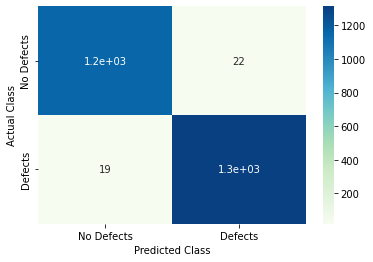

In [ ]:
_, cm, metrics_strings = performance_metrics(targets, preds_prob, report_type = 'total')
plot_confusion_matrix(cm)
metrics_table(metrics_strings)

,0,1
0,Accuracy,98.95%
1,Sensitivity,0.993
2,Specificity,0.985
3,True Positives,1302
4,True Negatives,1145
5,False Positives,17
6,False Negatives,9
7,Correct Predictions,2447
8,Incorrect Predictions,26
9,Total Observations,2512


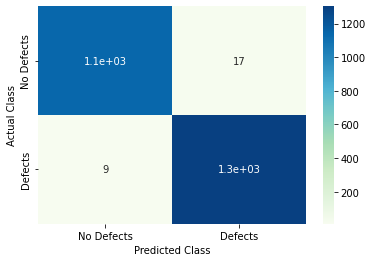

In [ ]:
#@markdown Adjusting prediction thresholds to limit results to higher confidence predictions.
pos_thresh = 0.65 #@param {type:"number"}
neg_thresh = 0.35 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')

plot_confusion_matrix(cm)
metrics_table(metrics_strings)

,0,1
0,Accuracy,99.46%
1,Sensitivity,0.999
2,Specificity,0.988
3,True Positives,1288
4,True Negatives,911
5,False Positives,11
6,False Negatives,1
7,Correct Predictions,2199
8,Incorrect Predictions,12
9,Total Observations,2512


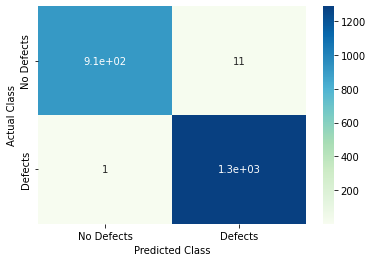

In [ ]:
#@markdown Adjusting prediction thresholds to minimize False Nagatives.
pos_thresh = 0.80 #@param {type:"number"}
neg_thresh = 0.03 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')

plot_confusion_matrix(cm)
metrics_table(metrics_strings)

,0,1
0,Accuracy,99.80%
1,Sensitivity,0.999
2,Specificity,0.997
3,True Positives,1088
4,True Negatives,911
5,False Positives,3
6,False Negatives,1
7,Correct Predictions,1999
8,Incorrect Predictions,4
9,Total Observations,2512


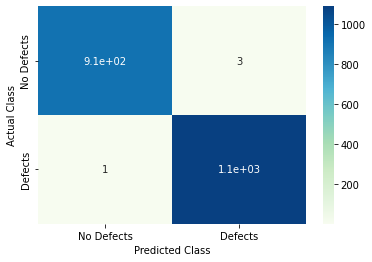

In [ ]:
#@markdown Adjusting prediction thresholds to minimize misclassification.
pos_thresh = 0.96 #@param {type:"number"}
neg_thresh = 0.03 #@param {type:"number"}

_, cm, metrics_strings = performance_metrics(targets, preds_prob, neg_thresh, 
                                    pos_thresh, report_type = 'high_confidence')

plot_confusion_matrix(cm)
metrics_table(metrics_strings)

In [ ]:
seg_df_rows = [create_df_row(w) for w in saved_weights if 'bin' not in w] 
seg_df = pd.DataFrame(seg_df_rows, columns = col_names)

best_seg = get_best_weights(seg_df, segmentation_ensemble_size)
best_seg_fold = best_seg[best_seg.fold==fold_num]
seg_keys = best_seg_fold.key.values

print('Segmentation Ensemble Components:')
display(best_seg_fold[col_names[1:7]])

Segmentation Ensemble Components:


,base,fold,size,score,metric,model_type
2,efficientnetb3,3,"(128, 800)",0.68573,dice,segmentation
3,efficientnetb1,3,"(128, 800)",0.68377,dice,segmentation
4,efficientnetb2,3,"(128, 800)",0.68229,dice,segmentation
5,efficientnetb4,3,"(128, 800)",0.65734,dice,segmentation
6,efficientnetb5,3,"(128, 800)",0.65687,dice,segmentation


## Segmentation Ensemble

In [ ]:
segmentation_ensemble = assemble_ensemble(seg_keys)
segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 Efficientnet-B3-Unet-M0 (Funct  (None, 128, 800, 4)  20925420   ['input_7[0][0]']                
 ional)                                                                                           
                                                                                                  
 Efficientnet-B1-Unet-M1 (Funct  (None, 128, 800, 4)  15240004   ['input_7[0][0]']                
 ional)                                                                       

In [ ]:
segmentation_ensemble = assemble_ensemble(seg_keys)
segmentation_ensemble.summary()

Model: "Segmentation_Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 Efficientnet-B3-Unet-M0 (Funct  (None, 128, 800, 4)  20925420   ['input_13[0][0]']               
 ional)                                                                                           
                                                                                                  
 Efficientnet-B1-Unet-M1 (Funct  (None, 128, 800, 4)  15240004   ['input_13[0][0]']               
 ional)                                                                       

In [ ]:
# split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)

def split_dataset(ds, steps, n_parts = 3):
    '''
    Splits a tensorflow Dataset API dataset into n_parts
    Args:
        ds: a batched tensorflow data.Dataset dataset
        steps: (int) the number of batches in the Dataset
        n_parts: (int) the number of output datasets
    Returns a tuple with n_parts data.Dataset datasets
    '''
    len_part = np.ceil(steps/n_parts).astype(int)    
    ds_remain = ds
    ds_parts = []
    for d in range(n_parts):
        dset = ds_remain.take(len_part)
        ds_parts.append(dset)
        ds_remain = ds_remain.skip(len_part)
    return ds_parts

In [ ]:
n_parts = 3
dsets, counts, steps, _ = get_eval_datasets(fold_num, target_size, 'mask')
valid_ds_parts = split_dataset(dsets['valid'], steps['valid'], n_parts = n_parts)

In [ ]:
meta_dict = meta_df.to_dict()
empty_mask = np.zeros(target_size, int) 
n_demo =  200 # will keep some examples to show prediction examples

## Final Inference

In [ ]:
binary_thresh = 0.55
thresh_upper = [0.7, 0.7, 0.7, 0.7]
thresh_lower = [0.4, 0.5, 0.4, 0.5]
min_area     = [180, 260, 200, 500]

In [ ]:
demo_preds = [];   # for plots  
dices = [], [], [], []; 
i = 0; 
start_preds = time()
for p, ds_part in enumerate(valid_ds_parts):
    print('\nPredicting and processing part {} of {}'.format(p+1, n_parts))
    
    preds = segmentation_ensemble.predict(ds_part, verbose = 1)    # shape 128, 800, 4
    
    gt_masks = [m.numpy().squeeze() for m in ds_part.map(lambda x, y: y).unbatch()]
    
    print('Shape of predictions part {}: {}'.format(p+1, preds.shape))
    
    for gt_mask, pred in zip(gt_masks, preds):
        pred_mask = np.zeros(pred.shape, int)
        demo = False

        # Start validation from i=0
        if meta_dict['preds_prob'][i]  > binary_thresh:
            for ch in range(N_DEFECT_CLASSES):  # 0, 1, 2, 3  
                ch_truth = gt_mask[..., ch]    # all matrices, all rows, column for ch = 0,1,2,3 , equivalent to c[:, :, ch]
                ch_probs = pred[..., ch]
                ch_pred = (ch_probs > thresh_upper[ch]).astype(int) 
                
                if ch_pred.sum() < min_area[ch]:
                    ch_pred = empty_mask
                else:
                    ch_pred = (ch_probs > thresh_lower[ch]).astype(int)
                    pred_mask[..., ch] = ch_pred
                    demo = True   # only save these for plots
                    
                dc = dice_coefficient(ch_truth, ch_pred)
                dices[ch].append(dc.numpy())
        else:
            for ch in range(N_DEFECT_CLASSES):
                ch_truth = gt_mask[..., ch]
                dc = dice_coefficient(ch_truth, empty_mask)
                dices[ch].append(dc.numpy())

        if demo and len(demo_preds) < n_demo: 
            demo_preds.append([i, gt_mask, pred_mask])

        i += 1

    del preds, gt_masks, pred, gt_mask

print('\nElapsed time {}'.format(time_passed(start_preds)))
print('Average Dice coefficient:', np.mean(dices))
ch_dices = ['Class {}: {:.4f}'.format(i+1, dc) for i, dc in zip(range(4), [np.mean(d) for d in dices])]
print('\nAverage Dice coefficient per type of defect: ', (4*'\n{}').format(*ch_dices))


Predicting and processing part 1 of 3
14/14 [==============================] - 116s 614ms/step
Shape of predictions part 1: (896, 128, 800, 4)

Predicting and processing part 2 of 3
14/14 [==============================] - 13s 623ms/step
Shape of predictions part 2: (896, 128, 800, 4)

Predicting and processing part 3 of 3
12/12 [==============================] - 12s 593ms/step
Shape of predictions part 3: (720, 128, 800, 4)

Elapsed time 05:46
Average Dice coefficient: 0.9465844

Average Dice coefficient per type of defect:  
Class 1: 0.9623
Class 2: 0.9893
Class 3: 0.8515
Class 4: 0.9832


In [ ]:
images_ds = dsets['valid'].map(lambda x, y: x).unbatch()
masked_idxs = [p[0] for p in demo_preds]
imgs = []
for i, img in enumerate(images_ds):
    if i in masked_idxs: 
        imgs.append(img)
        if len(imgs) == n_demo: break

demo_tuples = [(imgs[i], d[1], d[2]) for i, d in enumerate(demo_preds)]

In [ ]:
def plot_gt_vs_pred(pred_demo):
    fig, axs = plt.subplots(2, 1, figsize=(12, 3))
    rgb_colors = mask_rgb
    titles = 'Ground Truth', 'Prediction'
    for x, title in enumerate(titles):
        ax = fig.axes[x]
        ax.imshow(pred_demo[0])
        mask = pred_demo[x+1]
        masks = [(contoured_mask(mask[..., c], rgb_color = rgb_colors[c], 
                                 alpha=0.3)) for c in range(mask.shape[-1])]
        [ax.imshow(m, alpha = 1) for m in masks]
        ax.axis('off')
        ax.set_title(title, fontdict={'fontsize': 13})
    plt.tight_layout()
    plt.show()
    return None

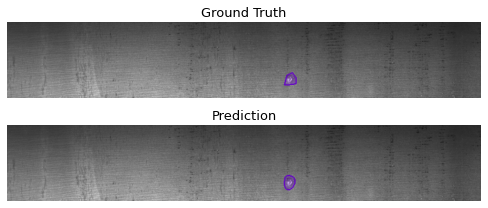

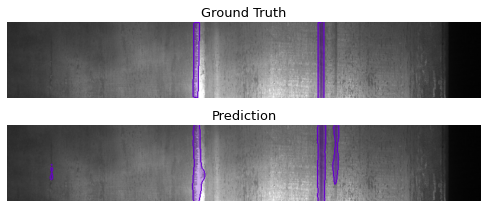

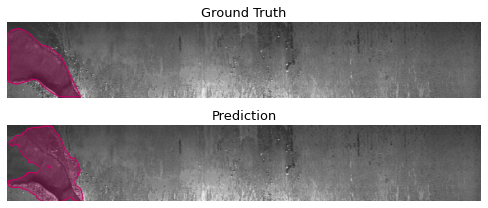

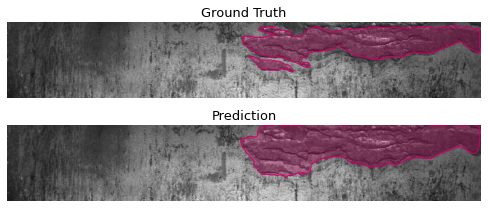

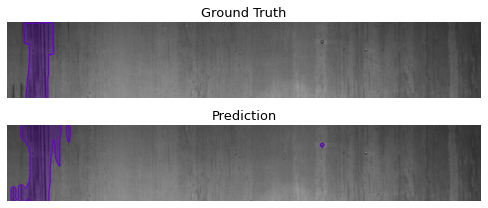

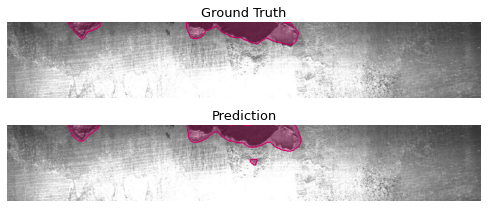

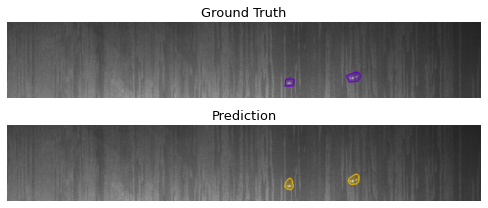

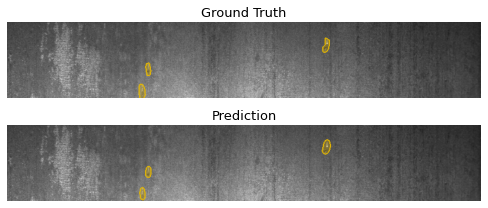

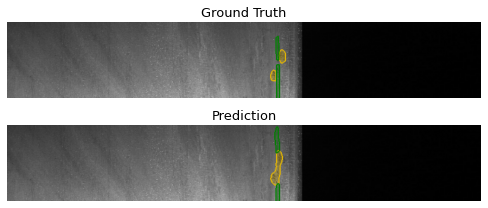

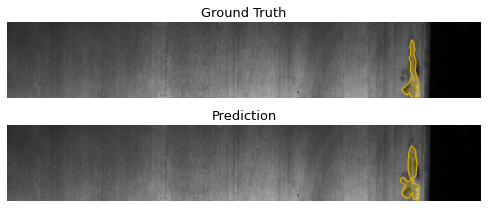

In [ ]:
for i in np.random.choice(n_demo, 10, replace=False):
    plot_gt_vs_pred(demo_tuples[i])